# Learning PageRank

### Overview

This Jupyter Notebook covers the **implementation of two simple Graph Neural Networks** (GNN) that are able to learn and determine the PageRank value of a graph.

As such, the repository covers:
- A program to compute the PageRank value of a given graph
- A random graph generator based on Erdos' random graph and scale-free generation
- A GNN with relaxation
- A GNN with a convolutional graph approach

The python implementations are available in the `script` folder and will be imported in this notebook. 

#### Note & Citation

This notebook relies heavily on the `networkx` library:

> Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008

And the `torch_gnn` package:

> Matteo Tiezzi, Giuseppe Marra, Stefano Melacci, Marco Maggini and Marco Gori (2020). "A Lagrangian Approach to Information Propagation in Graph Neural Networks; ECAI2020

### Library imports

```sh
pip install dgl==0.6.1
pip install torch==1.9.1
```

In [1]:
import networkx as nx
import numpy as np
import torch

from scripts.dataset import concatenate_graph_dataset
from scripts.dataset import generate_graph_dataset
from scripts.dataset import load_concatenated_graph_dataset
from scripts.dataset import PageRankDataset
from scripts.functions import generate_erdos_graph
from scripts.functions import generate_scale_free_graph
from scripts.functions import plot_graph
from scripts.functions import override_torch_gnn_library
from scripts.graph_networks import PageRankModelingWithGNN
from scripts.page_rank import page_rank
from scripts.random_graph_generator import Random_Graph_Generator

%matplotlib inline

Using backend: pytorch


In [2]:
override_torch_gnn_library() # skip_download=False to download/override torch_gnn

In [3]:
from torch_gnn.regression_gnn_wrapper import PageRankModelingWithRelaxationGNN

/home/quentin/anaconda3/envs/ML_base/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/quentin/anaconda3/envs/ML_base/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK2at10TensorBase21__dispatch_contiguousEN3c1012MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


## 1. Implementing a Custom PageRank Function

### 1.1. The Concept of PageRank

#### Overview

PageRank or $PR$ is an link analysis algorithm used by Google to rank web pages. 

Considering pages as node of a (web)graph, hyperlinks or references between pages are considered as edges of said graph. The PageRank of a node is the numerical weight representing the importance of the node in the graph, which is computed by the number of incoming link to the node existing within the graph itself. 

> Page, Lawrence and Brin, Sergey and Motwani, Rajeev and Winograd, Terry (1999) The PageRank Citation Ranking: Bringing Order to the Web. Technical Report. Stanford InfoLab.

#### Overview of the Algorithm

The PageRank algorithm is recursive as any PageRank value of a node of a graph is derived from the PageRank values of other nodes. 

<u>Initialization:</u>

Given a graph $G$ with nodes $\forall i\in\{0,1,\ldots,n\}, N_i\in G$. Edges corresponds to links between each nodes (no node self-references). Each node is initialized with a PageRank value drawn from a probability distribution with domain $[0,1]$ and summing to 1. 

A node $N_i$ transfers its PageRank value to the node $N_j$ it references (i.e. via an outbound link $N_i\rightarrow N_j$). The value transfer is done in equal proportion between each link $\forall j\in\{0,\ldots,n\},i\neq j, N_i\rightarrow N_j$. 

<u>Page Rank computation:</u>

As such, the PageRank amount granted to a node $N_j$ from a node $N_i$ via an outbound link $N_i\rightarrow N_j$ is:

$\forall i, j\in\{0,1,\ldots,n\},i\neq j,$
\begin{align}
N_i, N_j&\in G\\
PR_{\text{transferred},\,N_i\rightarrow N_j}(N_i)&=\frac{PR(N_i)}{L(N_i)}\\
L(N_i)&=\overset{n}{\underset{i=0\\i\neq j}{\sum}}\mathbb{1}_{\exists N_i\rightarrow N_j}
\end{align}

Consequently, the PageRank value of a single node $N_i$ is:

$$\forall i, j\in\{0,1,\ldots,n\},i\neq j,\,PR(N_i)=\frac{1-d}{n}+d\big(\overset{n}{\underset{j\in\mathcal{M}(i)}{\sum}}PR_{\text{transferred},\,N_j\rightarrow N_i}(N_j)\big)$$

With $\mathcal{M}(i)$ the set of nodes $N_j$ that link to node $N_i$, $d$ a damping vactor (often set to $0.85$) that captures the idea that a random walker on the web will continue clicking on links on a page/node as a reducing rate.

#### Note on PageRank and Message Passing Models

We find some similarities between the way PageRank is computed and a generic model description of Graph Neural Networks based on message exchange among neighbors. Many GNN models can be described using this formalism called *Message Passing*, which helps understand how information propagates within a graph.

<center><img src="assets/message_passing.gif" width="400"></center>

### 1.2. Iterative Implementation

We decide to implement PageRank's iterative method described as such:

#### Initialization

- $n$, the number of nodes in the graph
- $t=0$, the starting timestep
- $\forall i\in\{0, \ldots, n\},\,PR(N_i; t=0)=\frac{1}{n}$, the starting PageRank of a node $N_i$ at time $t=0$
- $d\in[0, 1]$, the damping factor (usually set to $0.85$)
- $\epsilon$, an error parameter used to stop the algorithm

#### Iterative Steps

At each time step,

\begin{align}
\forall i\in\{0, \ldots, n\},\,PR(N_i; t+1)&=\frac{1-d}{n}+d\big(\overset{n}{\underset{j\in\mathcal{M}(i)}{\sum}}\frac{PR(N_j)}{L(N_j)}\big)\\
\end{align}

We denote $R(t)$ the column vector of length $n$ which row values are $\forall i \in \{0, \ldots, n\}, PR(N_i; t)$.

#### Iteration Stop

The above iterative process stops when: $$|R(t+1)-R(t)|<\epsilon$$

This assumes that the process has converged.

#### Example implementation

The full code is avalaible in the file `scripts/page_rank.py`.

In [4]:
# Generates a probabilistic transition matrix M
# of a graph with 10 nodes
M = np.random.random(size=(10, 10))
N = np.random.randint(0, 2, size=(10, 10))
M = M*N # adds zeros
M = M/M.sum(axis=0) # sums columns to one

print("Transition matrix M:\n", np.round(M, 1))

Transition matrix M:
 [[0.1 0.  0.2 0.  0.  0.  0.1 0.  0.2 0. ]
 [0.  0.  0.  0.  0.5 0.3 0.  0.  0.1 0. ]
 [0.2 0.5 0.3 0.  0.1 0.  0.3 0.1 0.2 0. ]
 [0.2 0.  0.  0.7 0.  0.1 0.  0.  0.1 0. ]
 [0.  0.  0.  0.  0.  0.1 0.2 0.  0.2 0. ]
 [0.1 0.  0.2 0.2 0.2 0.3 0.2 0.2 0.  0.7]
 [0.2 0.4 0.  0.  0.  0.  0.2 0.3 0.  0. ]
 [0.  0.1 0.  0.  0.2 0.  0.  0.1 0.1 0.3]
 [0.2 0.  0.2 0.1 0.  0.  0.  0.2 0.  0. ]
 [0.  0.  0.2 0.  0.  0.2 0.  0.  0.1 0. ]]


In [5]:
# Computes the PageRank of each of the 10 nodes
page_rank(M, print_convergence=True)

PageRank converged at iteration 9 with epsilon=1e-05.


array([[0.07074665],
       [0.09130777],
       [0.15702613],
       [0.12408015],
       [0.05402025],
       [0.19830785],
       [0.0914402 ],
       [0.06880737],
       [0.07331767],
       [0.07094595]])

## 2. Generating Random Graphs

### 2.1. Generating an Example Erdos Graph

In [6]:
g = generate_erdos_graph(10, 0.3)

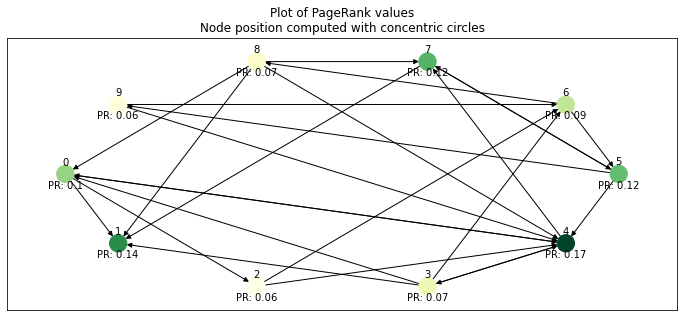

In [7]:
plot_graph(g, layout="shell")

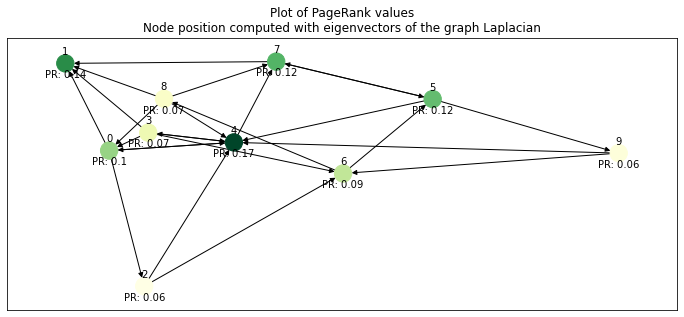

In [8]:
plot_graph(g, layout="spectral")

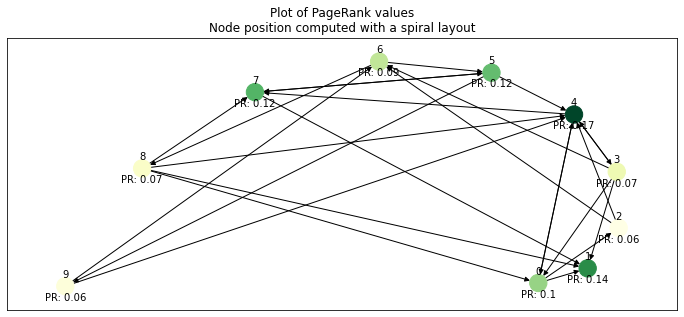

In [9]:
plot_graph(g, layout="spiral")

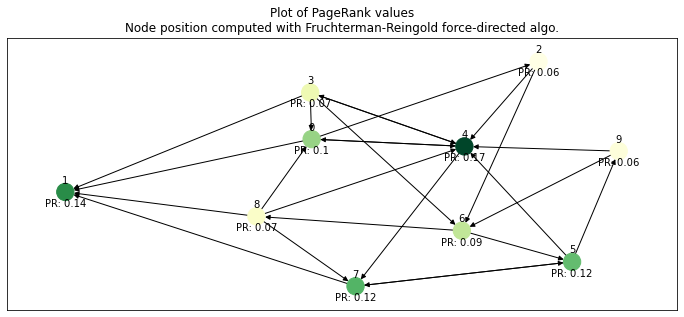

In [10]:
plot_graph(g, layout="spring")

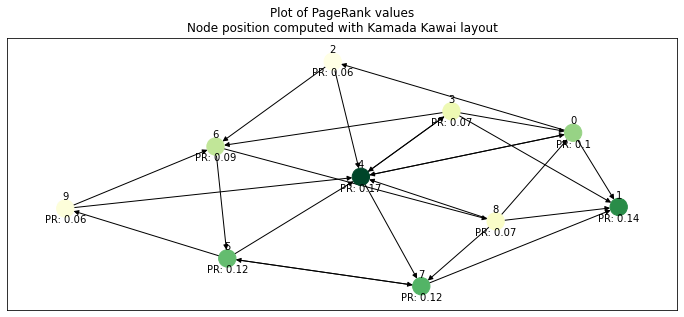

In [11]:
plot_graph(g, layout="kamada kawai")

### 2.2. Generating an Example Scale-Free Graph

In [12]:
g = generate_scale_free_graph(10)

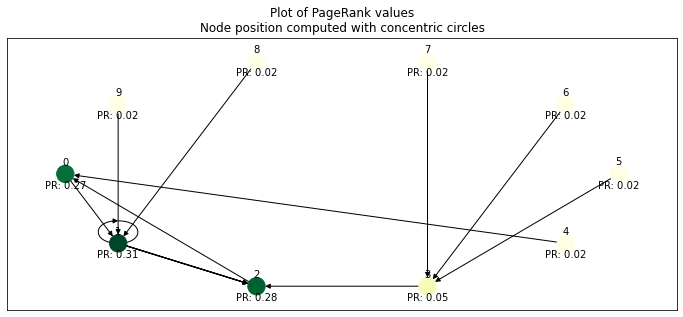

In [13]:
plot_graph(g, layout="shell")

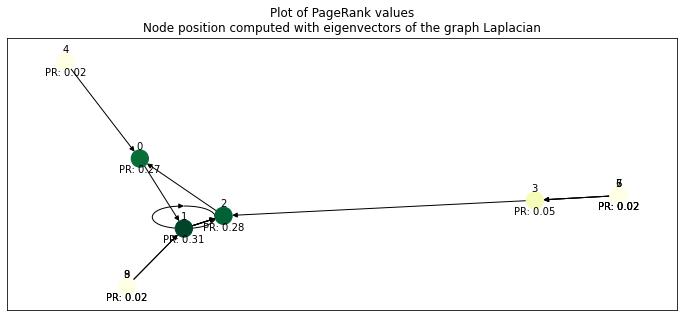

In [14]:
plot_graph(g, layout="spectral")

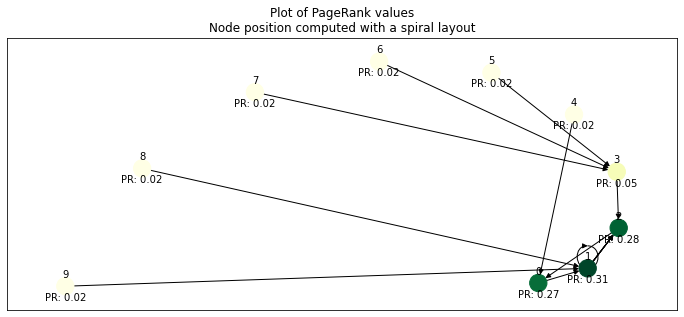

In [15]:
plot_graph(g, layout="spiral")

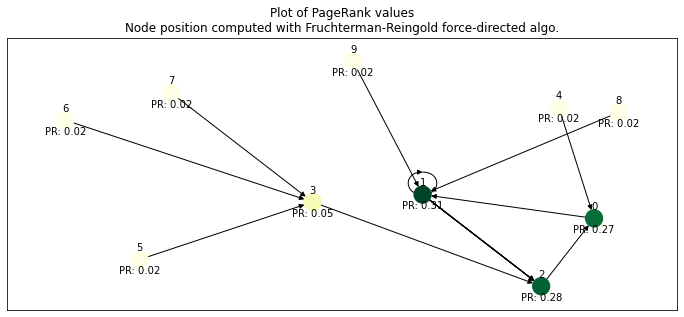

In [16]:
plot_graph(g, layout="spring")

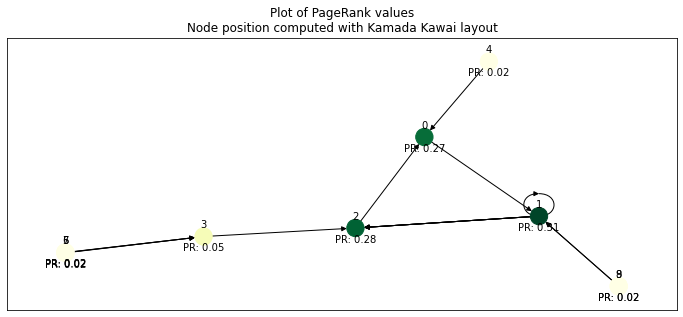

In [17]:
plot_graph(g, layout="kamada kawai")

### 2.2. Many Graphs Generation

#### Erdos' Method

The Erdős-Rényi graph or a binomial graph is a graph model that construct a graph $G_{n,p}$ where each of the possible edges between $n$ nodes appear with a fixed probability $p$. Each edge's probability of appearance is independent from the other edge's own probabilities.

> P. Erdős and A. Rényi, On Random Graphs, Publ. Math. 6, 290 (1959).

<u>Example</u>

In [18]:
erdos_generator = Random_Graph_Generator("erdos", True)
erdos_generator.graphs_generate(100, 5, 0.5)
erdos_generator.graphs_page_rank_compute()
eX, ey = erdos_generator.graphs_retrieve()

Erdos Graph Generator declared
5 graphs were generated
PageRank values computed


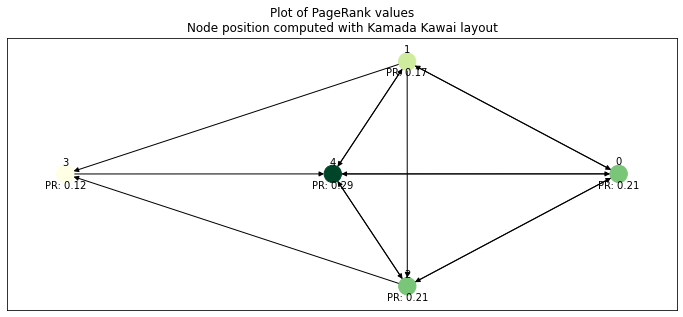

{0: 0.20713190376730042,
 1: 0.17083061594651897,
 2: 0.20713190376730042,
 3: 0.12498852554607587,
 4: 0.2899170509728042}

In [19]:
plot_graph(eX[50])
ey[50]

#### Scale-Free Method

The Scale-Free graph is a graph model that construct a graph $G_{n}$ of $n$ nodes with the property that the number of links $k$ originating from a given node exhibits a power law distribution $P(k)\sim k^(-\gamma)$. 

A scale-free network can be constructed by progressively adding nodes to an existing network and introducing links to existing nodes with preferential attachment so that the probability of linking to a given node $i$ is proportional to the number of existing links $k_i$ that node has such that:

$$P(\text{linking to node }i)\sim\frac{k_i}{\sum_jk_j}$$

> B. Bollobás, C. Borgs, J. Chayes, and O. Riordan, Directed scale-free graphs, Proceedings of the fourteenth annual ACM-SIAM Symposium on Discrete Algorithms, 132--139, 2003.

<u>Example</u>

In [20]:
scalefree_generator = Random_Graph_Generator("scale-free", True)
scalefree_generator.graphs_generate(100, 5)
scalefree_generator.graphs_page_rank_compute()
sfX, sfy = scalefree_generator.graphs_retrieve()

Scale-Free Graph Generator declared
5 graphs were generated
PageRank values computed


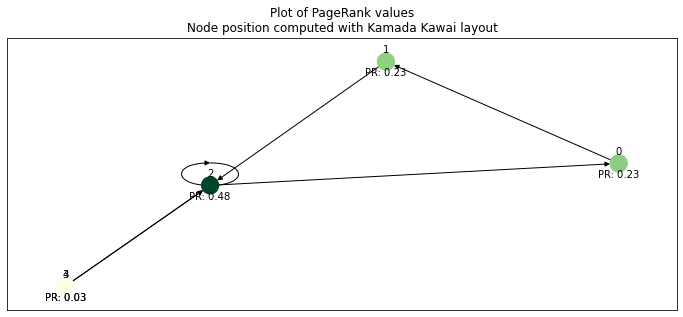

{0: 0.23331065691632785,
 1: 0.22831296845851926,
 2: 0.47837637462515314,
 3: 0.030000000000000006,
 4: 0.030000000000000006}

In [21]:
plot_graph(sfX[50])
sfy[50]

## 3. Learning PageRank

### 3.1. Building a Dataset
    
<u>Parameter selection</u>

To construct a dataset, we select:

- A **range of nodes $N$** to modulate the number of nodes in the graphs we want to create
- A selection of **graph-generating methods**. In our case: 
    - Erdos' method
    - Scale-Free method
- A **range of parameter values** for each parameter used to generate the graphs. In our case:
    - A range of probabilities $P$ to generate Erdos graphs
- A **number of graphs** to generate $n_{method}$ ***per given case and method***. In our case:
    - Erdos' method: we will obtain $n_{\text{erdos}}*len(P)*len(N)$
    - Scale-Free method: we will obtain $n_{\text{scale-free}}*len(N)$

As such, we choose to generate two graphs with either Erdos and Scale-Free graphs:

| Parameters | Description | Value | 
| :---: | :---: | :---: |
| P | Range of probabilities to generate Erdos graphs | {0.6} |
| N |  Range of nodes to generate graphs |  {60} |
| $n_{\text{erdos}}$ | Number of Erdos graphs to generate per case | 1 | 
| $n_{\text{scale-free}}$ | Number of Scale-Free graphs to generate per case | 2 |


In [22]:
# Declares the parameters

P            = [0.2]
N            = [15]
n_erdos      = 1
n_scale_free = 1

<u>Building the dataset</u>

We build 8 singular graphs each with a PageRank value per node, resulting in c. 70 nodes and 120 edges.

In [23]:
X, y = generate_graph_dataset(P, N, n_erdos, n_scale_free)

Generating Erdos graphs with parameters:
	Completed -- n=15, p=0.2

Generating Scale-Free graphs with parameter:
	Completed -- n=15


<u>Merging all graphs into a single entity and saving it</u>

We implement a function to concatenate all the generated graphs into a single large graph that can be used as input to a Graph Neural Network.

**Of note**, the cell is inactive on the assumption that it was already run and the result can be loaded using the load function located in the next cell.

In [24]:
pathX = "graph_files/graph_record02112022.graphml"
pathy = "graph_files/graph_record02112022_PageRanks.txt"

In [25]:
graphs, pageranks = concatenate_graph_dataset(X, y, pathX, pathy)

In [26]:
graphs, pageranks = load_concatenated_graph_dataset(pathX, pathy)

In [27]:
print(len(graphs.nodes), len(graphs.edges))

30 66


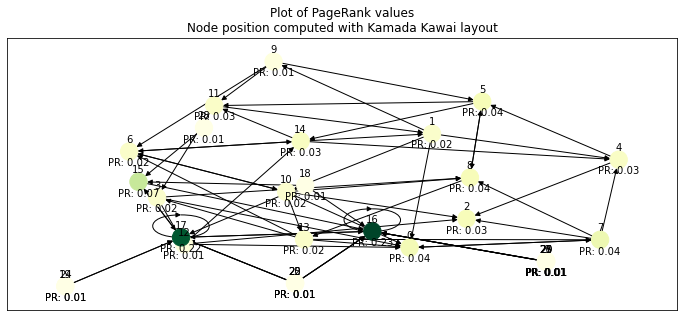

In [28]:
plot_graph(graphs)

<u>Building the DGL PageRank dataset</u>

In [29]:
dataset = PageRankDataset(graphs, pageranks, use_noise=True)
graph_noise_as_features = dataset[0]

dataset = PageRankDataset(graphs, pageranks, use_noise=False)
graph_torcheye_as_features = dataset[0]

### 3.2. Building Two Graph Neural Networks

<u>GNN with relaxation:</u>

In [30]:
# Declares important variables
graph  = graph_noise_as_features
E      = np.column_stack(graph.edges())
N      = graph.nodes()
labels = graph.ndata["label"].numpy()
train_mask = graph.ndata["train_mask"].numpy()
val_mask   = graph.ndata["test_mask"].numpy()
test_mask  = graph.ndata["val_mask"].numpy()

In [31]:
GNNrelaxation_model_adam = PageRankModelingWithRelaxationGNN(
    N, E, labels,
    train_mask, val_mask, test_mask,
    print_description = True
)


The model is a GNN based on a diffusion mechanism and relaxation.
A graph is processed by a set of nodes linked according to the
graph adjacency matrix/list of edges. The model updates the nodes' 
states by using an algorithm that shares information between 
(adjacent) nodes until an equilibrium state is reached. 

The output of the model is computed locally at each node based
on the node state.

The diffusion mechanism is constrained to ensure that a unique stable
equilibrium exists.

See also: https://persagen.com/files/misc/scarselli2009graph.pdf

Executing on device:  cpu


In [32]:
GNNrelaxation_model_adamw = PageRankModelingWithRelaxationGNN(
    N, E, labels,
    train_mask, val_mask, test_mask,
    optimizer = "AdamW"
)

Executing on device:  cpu


In [33]:
GNNrelaxation_model_adamax = PageRankModelingWithRelaxationGNN(
    N, E, labels,
    train_mask, val_mask, test_mask,
    optimizer = "Adamax"
)

Executing on device:  cpu


In [34]:
GNNrelaxation_model_adadelta = PageRankModelingWithRelaxationGNN(
    N, E, labels,
    train_mask, val_mask, test_mask,
    optimizer = "Adadelta"
)

Executing on device:  cpu


In [35]:
GNNrelaxation_model_SGD = PageRankModelingWithRelaxationGNN(
    N, E, labels,
    train_mask, val_mask, test_mask,
    optimizer = "SGD"
)

Executing on device:  cpu


<u>Convolutional GNN models (graph with noise as feature):</u>

In [36]:
# Declares important variables
hidden_features = 5
epochs = 1000

In [37]:
GCN_model_adam_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    print_description = True
)


The model was declared with GraphConv layers (2) which were introduced in:
> Semi-Supervised Classification with Graph Convolutional Networks
> by T. N. Kipf, M. Welling
> https://arxiv.org/pdf/1706.02216.pdf

Graph convolution is defined as follows:

```
h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}rac{1}{c_{ji}}h_j^{(l)}W^{(l)})
```

Where:
    - `\mathcal{N}(i)` is the set of neighbors of node `i`
    - `c_{ji}` is the product of the square root of node degrees
       `c_{ji} = \sqrt{|\mathcal{N}(j)|}\sqrt{|\mathcal{N}(i)|}`)
    - `\sigma` is an activation function.

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#graphconv



In [38]:
GCN_model_adamw_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "AdamW"
)

In [39]:
GCN_model_adamax_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "Adamax"
)

In [40]:
GCN_model_adadelta_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "Adadelta"
)

In [41]:
GCN_model_SGD_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "SGD"
)

In [42]:
SAGE_model_adam_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    print_description = True
)


The model was declared with GraphSAGE layers (2) which were introduced in:
> Inductive Representation Learning on Large Graphs
> by W.L. Hamiton, R. Ying, and J. Leskovec
> https://arxiv.org/pdf/1706.02216.pdf

The GraphSAGE Algorithm trains weight matrices instead of relying on 
embedding tables. It allows adding and removing nodes directly via the 
weight matrix. Nodes embeddings do not need to be recomputed.

```
egin{align}
    h_{\mathcal{N}(i)}^{(l+1)} &= 
        	ext{aggregate}
        \left(
            \{h_{j}^{l}, orall j \in \mathcal{N}(i) \}
ight) h_{i}^{(l+1)}
    \
    &= \sigma 
        \left(
            W \cdot \mathrm{concat} (h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) 
ight) h_{i}^{(l+1)} \
    &= \mathrm{norm}(h_{i}^{l})
\end{align}
```

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#sageconv



In [43]:
SAGE_model_adamw_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "AdamW"
)

In [44]:
SAGE_model_adamax_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "Adamax"
)

In [45]:
SAGE_model_adadelta_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "Adadelta"
)

In [46]:
SAGE_model_SGD_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "SGD"
)

<u>Convolutional GNN models (graph with torcheye as feature):</u>

In [47]:
# Declares important variables
hidden_features = 5
epochs = 1000

In [48]:
GCN_model_adam_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    print_description = True
)


The model was declared with GraphConv layers (2) which were introduced in:
> Semi-Supervised Classification with Graph Convolutional Networks
> by T. N. Kipf, M. Welling
> https://arxiv.org/pdf/1706.02216.pdf

Graph convolution is defined as follows:

```
h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}rac{1}{c_{ji}}h_j^{(l)}W^{(l)})
```

Where:
    - `\mathcal{N}(i)` is the set of neighbors of node `i`
    - `c_{ji}` is the product of the square root of node degrees
       `c_{ji} = \sqrt{|\mathcal{N}(j)|}\sqrt{|\mathcal{N}(i)|}`)
    - `\sigma` is an activation function.

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#graphconv



In [49]:
GCN_model_adamw_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "AdamW"
)

In [50]:
GCN_model_adamax_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "Adamax"
)

In [51]:
GCN_model_adadelta_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "Adadelta"
)

In [52]:
GCN_model_SGD_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "SGD"
)

In [53]:
SAGE_model_adam_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    print_description = True
)


The model was declared with GraphSAGE layers (2) which were introduced in:
> Inductive Representation Learning on Large Graphs
> by W.L. Hamiton, R. Ying, and J. Leskovec
> https://arxiv.org/pdf/1706.02216.pdf

The GraphSAGE Algorithm trains weight matrices instead of relying on 
embedding tables. It allows adding and removing nodes directly via the 
weight matrix. Nodes embeddings do not need to be recomputed.

```
egin{align}
    h_{\mathcal{N}(i)}^{(l+1)} &= 
        	ext{aggregate}
        \left(
            \{h_{j}^{l}, orall j \in \mathcal{N}(i) \}
ight) h_{i}^{(l+1)}
    \
    &= \sigma 
        \left(
            W \cdot \mathrm{concat} (h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) 
ight) h_{i}^{(l+1)} \
    &= \mathrm{norm}(h_{i}^{l})
\end{align}
```

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#sageconv



In [54]:
SAGE_model_adamw_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "AdamW"
)

In [55]:
SAGE_model_adamax_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "Adamax"
)

In [56]:
SAGE_model_adadelta_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "Adadelta"
)

In [57]:
SAGE_model_SGD_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "SGD"
)

### 3.3. Training the Graph Neural Networks

<u>GNN with relaxation (graph with noise as feature):</u>

Epoch -- 100
	Training -- Mean Loss: 0.0421, Iterations: 6
	Validation -- Mean Loss: 0.0587, Iterations: 6
Epoch -- 200
	Training -- Mean Loss: 0.0104, Iterations: 5
	Validation -- Mean Loss: 0.015, Iterations: 5
Epoch -- 300
	Training -- Mean Loss: 0.0094, Iterations: 5
	Validation -- Mean Loss: 0.015, Iterations: 5
Epoch -- 400
	Training -- Mean Loss: 0.0085, Iterations: 6
	Validation -- Mean Loss: 0.0152, Iterations: 6
Epoch -- 500
	Training -- Mean Loss: 0.0076, Iterations: 6
	Validation -- Mean Loss: 0.0153, Iterations: 6
Epoch -- 600
	Training -- Mean Loss: 0.0064, Iterations: 6
	Validation -- Mean Loss: 0.015, Iterations: 6
Epoch -- 700
	Training -- Mean Loss: 0.0043, Iterations: 5
	Validation -- Mean Loss: 0.0138, Iterations: 5
Epoch -- 800
	Training -- Mean Loss: 0.0025, Iterations: 5
	Validation -- Mean Loss: 0.0151, Iterations: 5
Epoch -- 900
	Training -- Mean Loss: 0.0012, Iterations: 6
	Validation -- Mean Loss: 0.0185, Iterations: 6
Epoch -- 1000
	Training -- Mean Loss: 0.

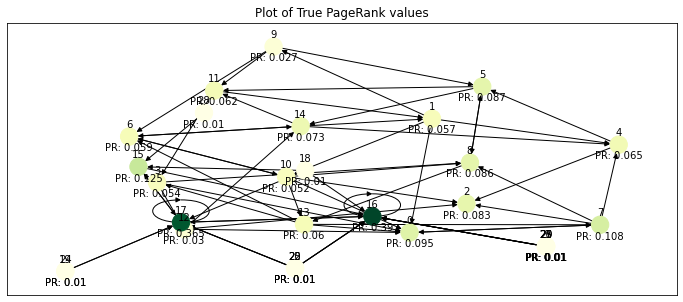

Plot with predicted labels
--------------------------


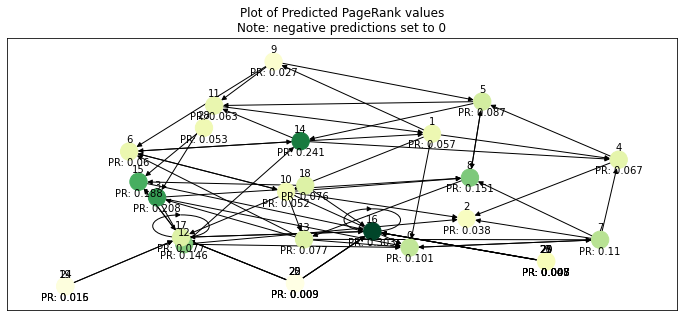

Ground Truth vs. Predictions
--------------------------


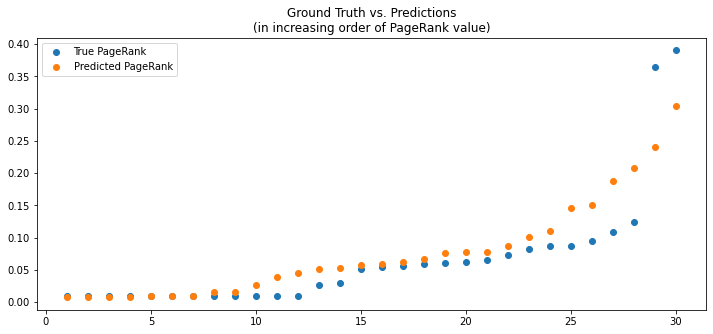

In [58]:
GNNrelaxation_model_adam.run(
    print_node_results=True, 
    print_graph_results=True
)

Epoch -- 100
	Training -- Mean Loss: 0.075, Iterations: 6
	Validation -- Mean Loss: 0.0737, Iterations: 6
Epoch -- 200
	Training -- Mean Loss: 0.0208, Iterations: 6
	Validation -- Mean Loss: 0.0169, Iterations: 6
Epoch -- 300
	Training -- Mean Loss: 0.0153, Iterations: 6
	Validation -- Mean Loss: 0.0156, Iterations: 6
Epoch -- 400
	Training -- Mean Loss: 0.0117, Iterations: 6
	Validation -- Mean Loss: 0.0155, Iterations: 6
Epoch -- 500
	Training -- Mean Loss: 0.0097, Iterations: 5
	Validation -- Mean Loss: 0.0157, Iterations: 5
Epoch -- 600
	Training -- Mean Loss: 0.0086, Iterations: 5
	Validation -- Mean Loss: 0.0161, Iterations: 5
Epoch -- 700
	Training -- Mean Loss: 0.008, Iterations: 5
	Validation -- Mean Loss: 0.0165, Iterations: 5
Epoch -- 800
	Training -- Mean Loss: 0.0076, Iterations: 5
	Validation -- Mean Loss: 0.0169, Iterations: 5
Epoch -- 900
	Training -- Mean Loss: 0.0074, Iterations: 5
	Validation -- Mean Loss: 0.0172, Iterations: 5
Epoch -- 1000
	Training -- Mean Loss: 0

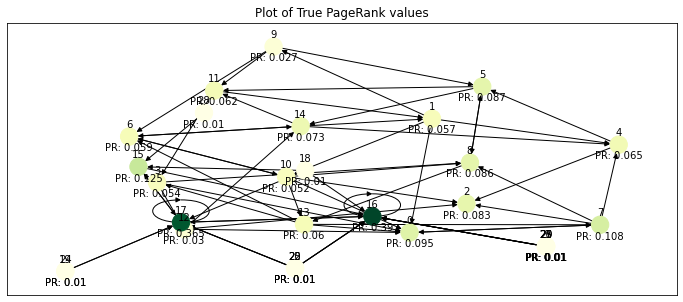

Plot with predicted labels
--------------------------


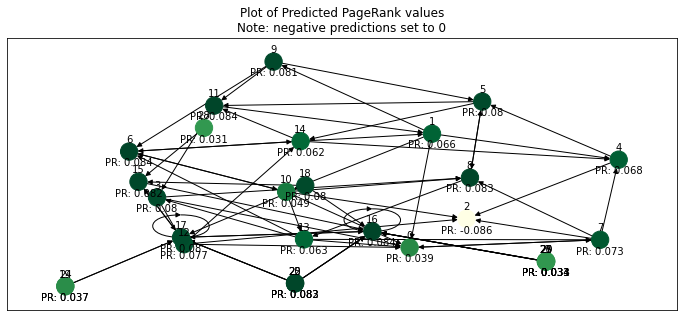

Ground Truth vs. Predictions
--------------------------


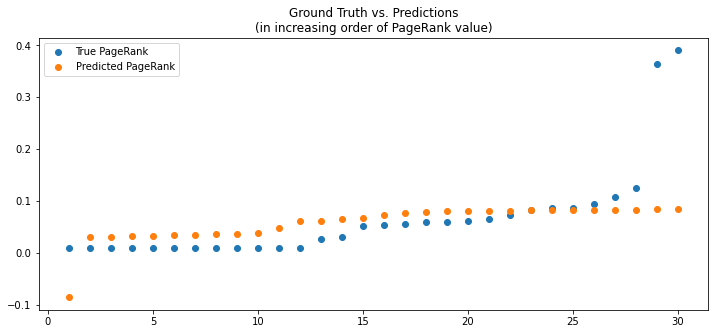

In [59]:
GNNrelaxation_model_adamw.run(
    print_node_results=True, 
    print_graph_results=True
)

Epoch -- 100
	Training -- Mean Loss: 0.0067, Iterations: 5
	Validation -- Mean Loss: 0.018, Iterations: 5
Epoch -- 200
	Training -- Mean Loss: 0.0057, Iterations: 4
	Validation -- Mean Loss: 0.018, Iterations: 4
Epoch -- 300
	Training -- Mean Loss: 0.0043, Iterations: 4
	Validation -- Mean Loss: 0.0176, Iterations: 4
Epoch -- 400
	Training -- Mean Loss: 0.0031, Iterations: 5
	Validation -- Mean Loss: 0.0173, Iterations: 5
Epoch -- 500
	Training -- Mean Loss: 0.002, Iterations: 5
	Validation -- Mean Loss: 0.0167, Iterations: 5
Epoch -- 600
	Training -- Mean Loss: 0.0012, Iterations: 5
	Validation -- Mean Loss: 0.0163, Iterations: 5
Epoch -- 700
	Training -- Mean Loss: 0.0007, Iterations: 6
	Validation -- Mean Loss: 0.0165, Iterations: 6
Epoch -- 800
	Training -- Mean Loss: 0.0004, Iterations: 7
	Validation -- Mean Loss: 0.0171, Iterations: 7
Epoch -- 900
	Training -- Mean Loss: 0.0002, Iterations: 8
	Validation -- Mean Loss: 0.0177, Iterations: 8
Epoch -- 1000
	Training -- Mean Loss: 1e

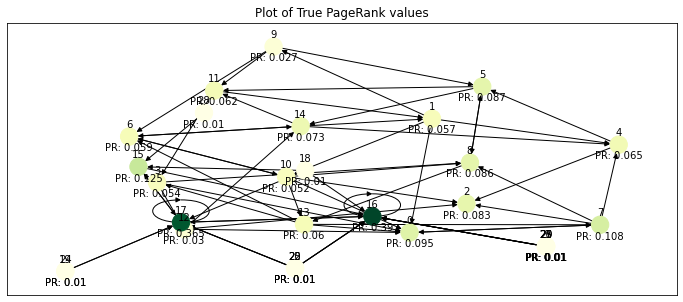

Plot with predicted labels
--------------------------


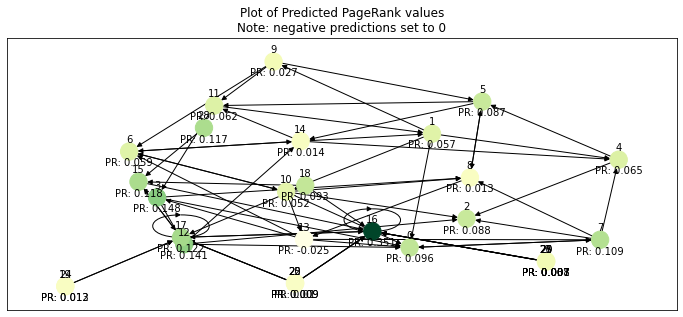

Ground Truth vs. Predictions
--------------------------


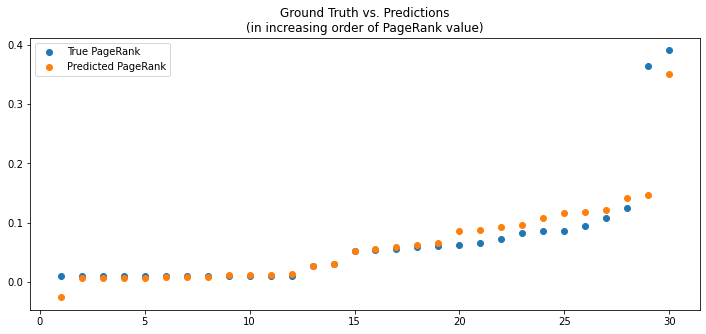

In [60]:
GNNrelaxation_model_adamax.run(
    print_node_results=True, 
    print_graph_results=True
)

Epoch -- 100
	Training -- Mean Loss: 0.192, Iterations: 5
	Validation -- Mean Loss: 0.1672, Iterations: 5
Epoch -- 200
	Training -- Mean Loss: 0.1896, Iterations: 5
	Validation -- Mean Loss: 0.165, Iterations: 5
Epoch -- 300
	Training -- Mean Loss: 0.1869, Iterations: 5
	Validation -- Mean Loss: 0.1624, Iterations: 5
Epoch -- 400
	Training -- Mean Loss: 0.1838, Iterations: 5
	Validation -- Mean Loss: 0.1596, Iterations: 5
Epoch -- 500
	Training -- Mean Loss: 0.1805, Iterations: 5
	Validation -- Mean Loss: 0.1565, Iterations: 5
Epoch -- 600
	Training -- Mean Loss: 0.177, Iterations: 5
	Validation -- Mean Loss: 0.1532, Iterations: 5
Epoch -- 700
	Training -- Mean Loss: 0.1733, Iterations: 5
	Validation -- Mean Loss: 0.1498, Iterations: 5
Epoch -- 800
	Training -- Mean Loss: 0.1695, Iterations: 5
	Validation -- Mean Loss: 0.1462, Iterations: 5
Epoch -- 900
	Training -- Mean Loss: 0.1655, Iterations: 5
	Validation -- Mean Loss: 0.1425, Iterations: 5
Epoch -- 1000
	Training -- Mean Loss: 0.

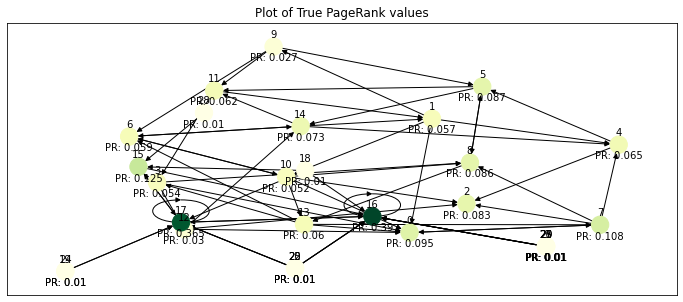

Plot with predicted labels
--------------------------


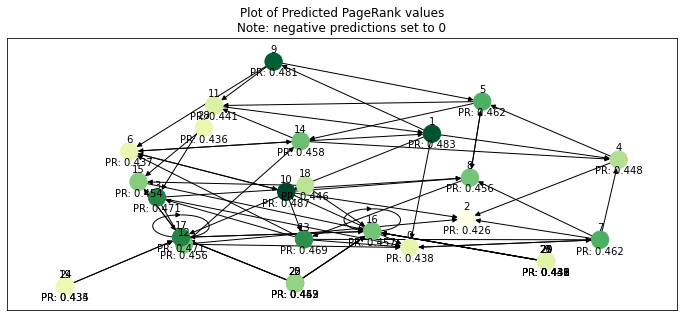

Ground Truth vs. Predictions
--------------------------


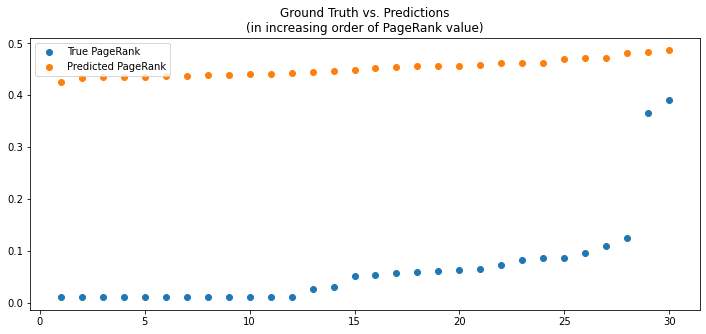

In [61]:
GNNrelaxation_model_adadelta.run(
    print_node_results=True, 
    print_graph_results=True
)

Epoch -- 100
	Training -- Mean Loss: 0.0067, Iterations: 5
	Validation -- Mean Loss: 0.0196, Iterations: 5
Epoch -- 200
	Training -- Mean Loss: 0.0067, Iterations: 5
	Validation -- Mean Loss: 0.0198, Iterations: 5
Epoch -- 300
	Training -- Mean Loss: 0.0066, Iterations: 5
	Validation -- Mean Loss: 0.02, Iterations: 5
Epoch -- 400
	Training -- Mean Loss: 0.0066, Iterations: 5
	Validation -- Mean Loss: 0.0201, Iterations: 5
Epoch -- 500
	Training -- Mean Loss: 0.0066, Iterations: 5
	Validation -- Mean Loss: 0.0202, Iterations: 5
Epoch -- 600
	Training -- Mean Loss: 0.0066, Iterations: 5
	Validation -- Mean Loss: 0.0202, Iterations: 5
Epoch -- 700
	Training -- Mean Loss: 0.0066, Iterations: 5
	Validation -- Mean Loss: 0.0202, Iterations: 5
Epoch -- 800
	Training -- Mean Loss: 0.0066, Iterations: 5
	Validation -- Mean Loss: 0.0202, Iterations: 5
Epoch -- 900
	Training -- Mean Loss: 0.0066, Iterations: 5
	Validation -- Mean Loss: 0.0203, Iterations: 5
Epoch -- 1000
	Training -- Mean Loss: 0

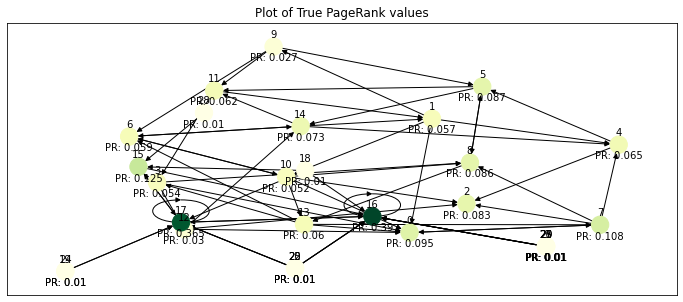

Plot with predicted labels
--------------------------


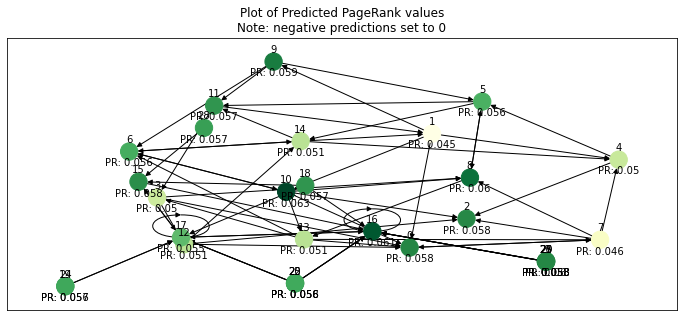

Ground Truth vs. Predictions
--------------------------


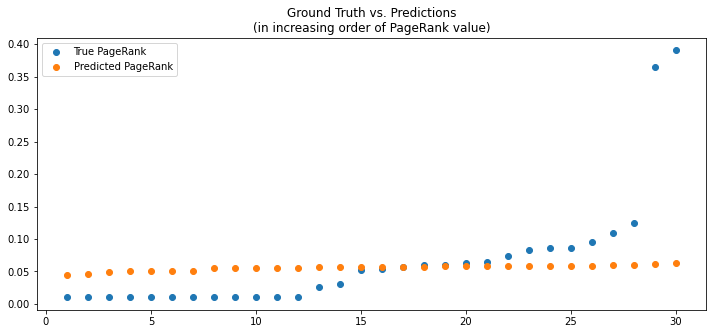

In [62]:
GNNrelaxation_model_SGD.run(
    print_node_results=True, 
    print_graph_results=True
)

<u>Convolutional GNN models (graph with noise as feature):</u>

Epoch 0,	loss: 0.106212;		val loss 0.032303
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 34             ####
Final train loss: 0.006167, validation loss: 0.0013081141514703631.
Test loss: 0.001898


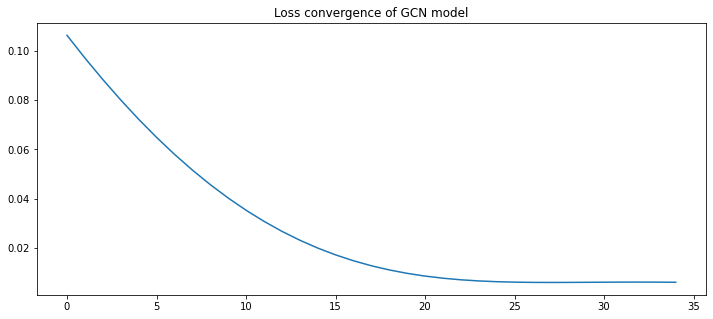



Plot with true labels
---------------------


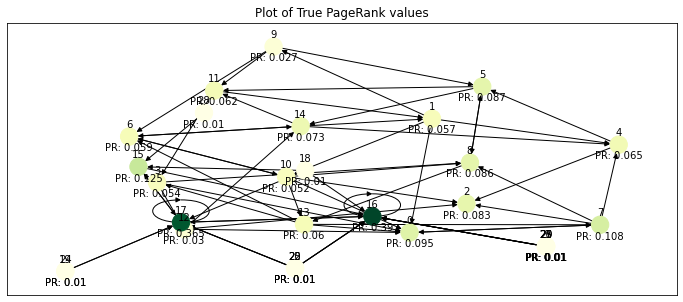

Plot with predicted labels
--------------------------


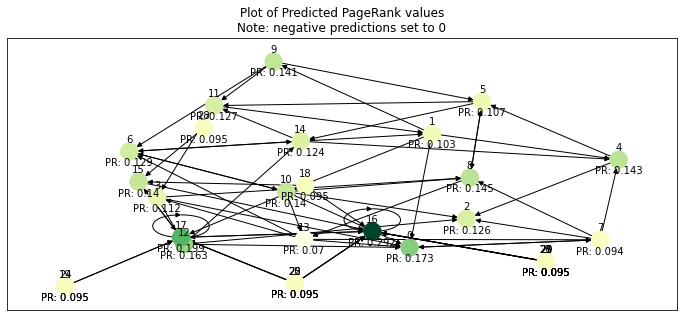

Ground Truth vs. Predictions
--------------------------


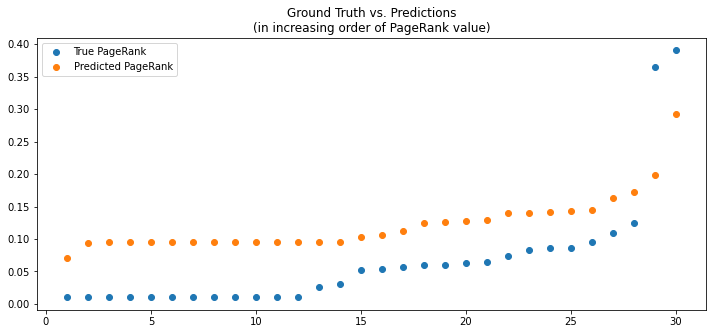

In [63]:
GCN_model_adam_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.069298;		val loss 0.020246
Epoch 50,	loss: 0.010888;		val loss 0.000831
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 63             ####
Final train loss: 0.009751, validation loss: 0.0008330340497195721.
Test loss: 0.005758


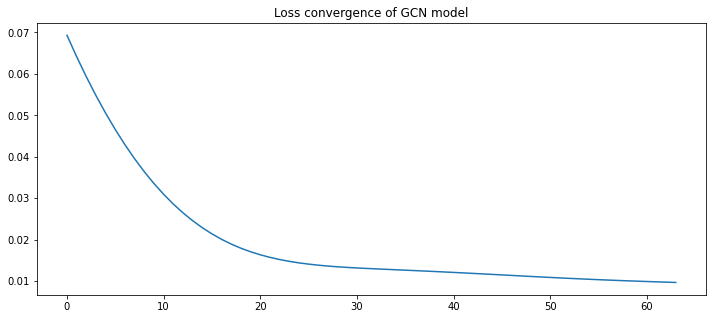



Plot with true labels
---------------------


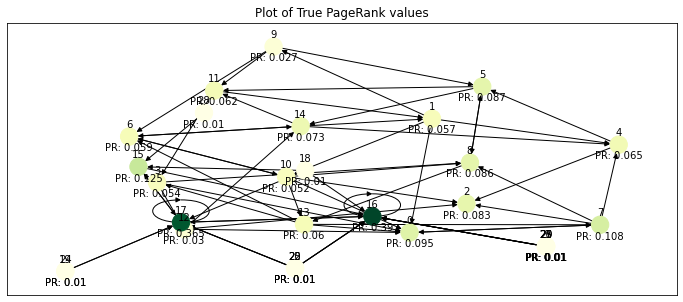

Plot with predicted labels
--------------------------


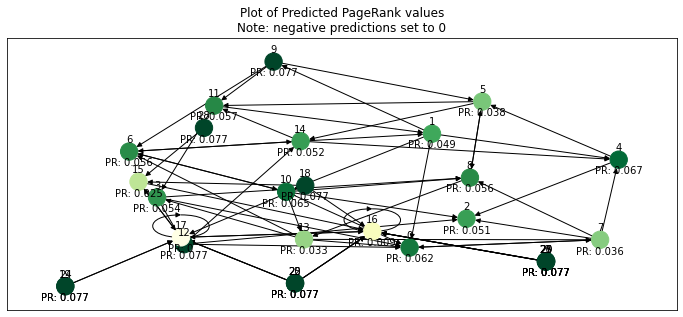

Ground Truth vs. Predictions
--------------------------


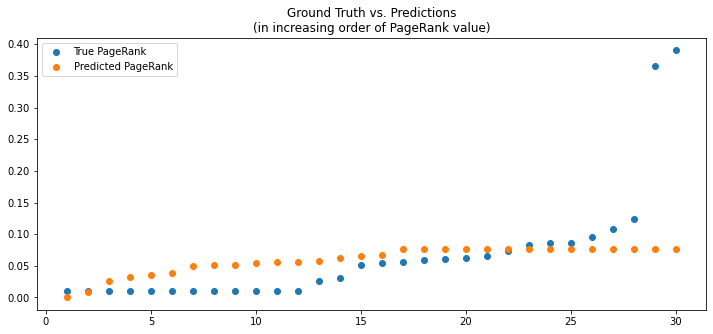

In [64]:
GCN_model_adamw_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.03155;		val loss 0.011824
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 41             ####
Final train loss: 0.00485, validation loss: 0.0009951102547347546.
Test loss: 0.001412


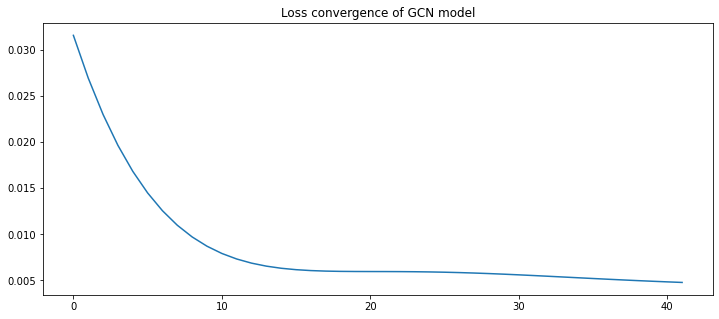



Plot with true labels
---------------------


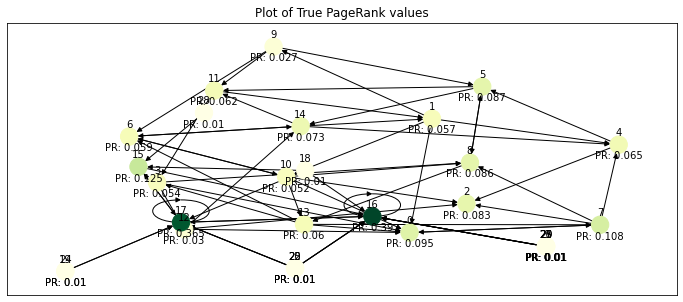

Plot with predicted labels
--------------------------


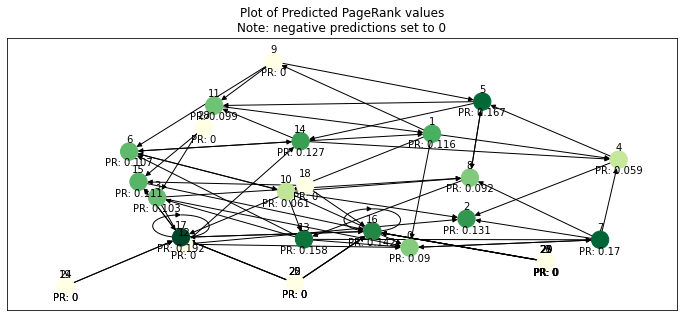

Ground Truth vs. Predictions
--------------------------


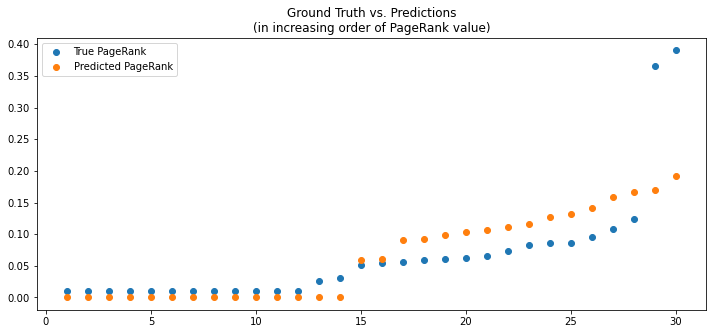

In [65]:
GCN_model_adamax_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.024649;		val loss 0.010743
Epoch 50,	loss: 0.02388;		val loss 0.010412
Epoch 100,	loss: 0.023013;		val loss 0.01004
Epoch 150,	loss: 0.022082;		val loss 0.009637
Epoch 200,	loss: 0.021106;		val loss 0.009214
Epoch 250,	loss: 0.020103;		val loss 0.008776
Epoch 300,	loss: 0.019086;		val loss 0.008329
Epoch 350,	loss: 0.01807;		val loss 0.007879
Epoch 400,	loss: 0.017063;		val loss 0.007429
Epoch 450,	loss: 0.016075;		val loss 0.006985
Epoch 500,	loss: 0.015114;		val loss 0.006547
Epoch 550,	loss: 0.014186;		val loss 0.006121
Epoch 600,	loss: 0.013297;		val loss 0.005707
Epoch 650,	loss: 0.012451;		val loss 0.005308
Epoch 700,	loss: 0.011651;		val loss 0.004925
Epoch 750,	loss: 0.010901;		val loss 0.00456
Epoch 800,	loss: 0.010201;		val loss 0.004214
Epoch 850,	loss: 0.009553;		val loss 0.003888
Epoch 900,	loss: 0.008958;		val loss 0.003581
Epoch 950,	loss: 0.008414;		val loss 0.003295
Final train loss: 0.007931, validation loss: 0.003034.
Test loss: 0.001197


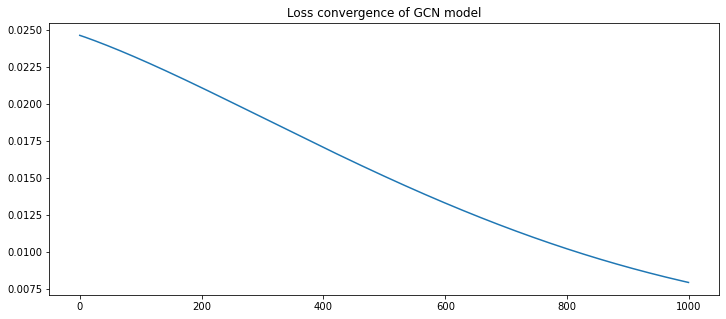



Plot with true labels
---------------------


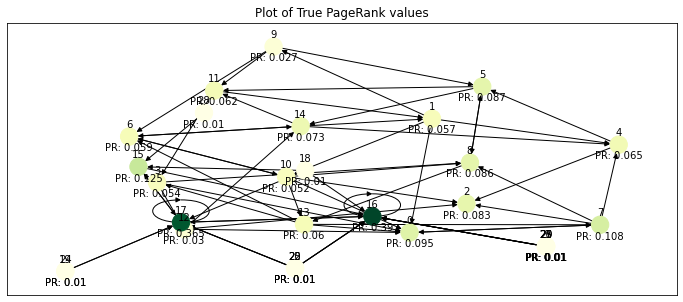

Plot with predicted labels
--------------------------


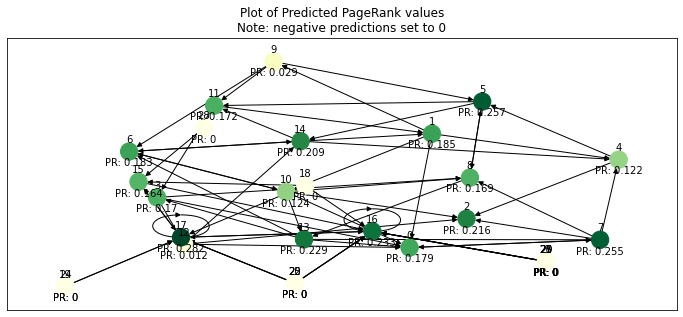

Ground Truth vs. Predictions
--------------------------


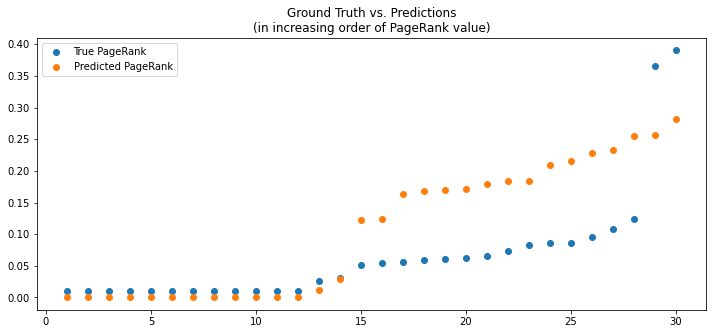

In [66]:
GCN_model_adadelta_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.004761;		val loss 0.000322
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 41             ####
Final train loss: 0.003692, validation loss: 0.00025377317797392607.
Test loss: 0.002278


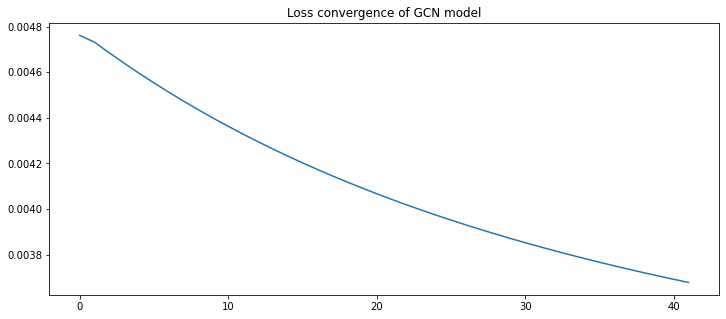



Plot with true labels
---------------------


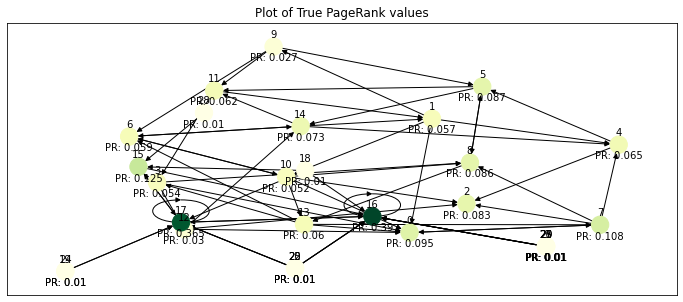

Plot with predicted labels
--------------------------


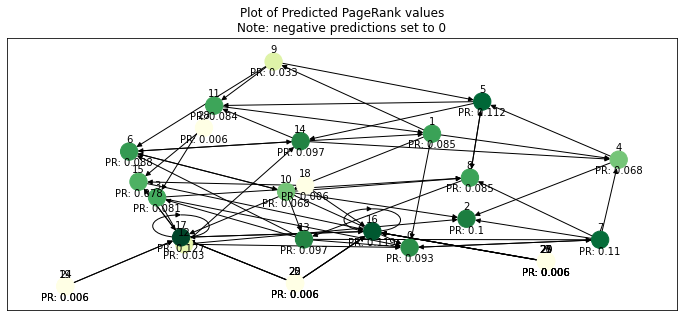

Ground Truth vs. Predictions
--------------------------


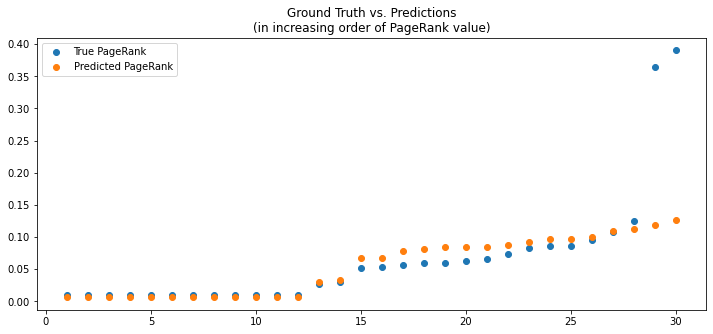

In [67]:
GCN_model_SGD_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.160592;		val loss 0.099865
Epoch 50,	loss: 0.019538;		val loss 0.011153
Epoch 100,	loss: 0.009302;		val loss 0.003866
Epoch 150,	loss: 0.007552;		val loss 0.002123
Epoch 200,	loss: 0.006611;		val loss 0.00139
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 225             ####
Final train loss: 0.006296, validation loss: 0.0012843419099226594.
Test loss: 0.001986


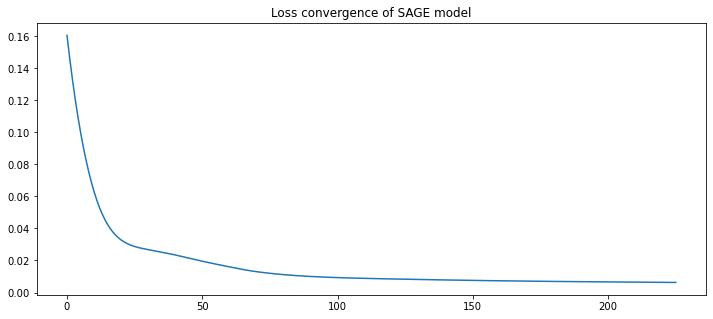



Plot with true labels
---------------------


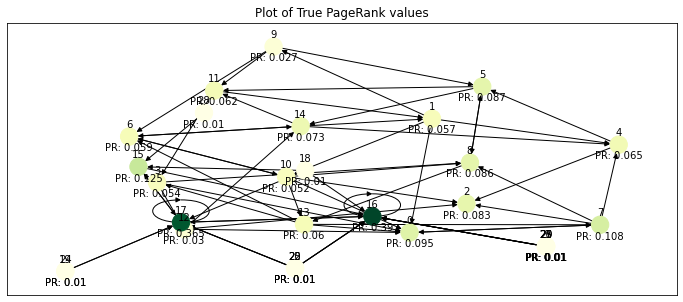

Plot with predicted labels
--------------------------


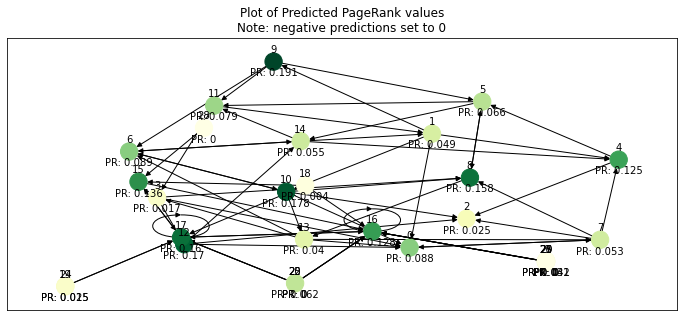

Ground Truth vs. Predictions
--------------------------


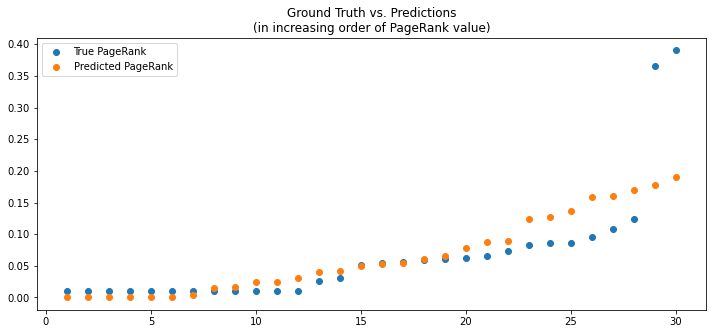

In [68]:
SAGE_model_adam_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.562014;		val loss 0.36142
Epoch 50,	loss: 0.027806;		val loss 0.018855
Epoch 100,	loss: 0.011881;		val loss 0.009916
Epoch 150,	loss: 0.004909;		val loss 0.003555
Epoch 200,	loss: 0.003633;		val loss 0.002153
Epoch 250,	loss: 0.003347;		val loss 0.001688
Epoch 300,	loss: 0.003192;		val loss 0.001431
Epoch 350,	loss: 0.003053;		val loss 0.001253
Epoch 400,	loss: 0.00292;		val loss 0.001169
Epoch 450,	loss: 0.00276;		val loss 0.001051
Epoch 500,	loss: 0.002595;		val loss 0.000882
Epoch 550,	loss: 0.002451;		val loss 0.000776
Epoch 600,	loss: 0.002322;		val loss 0.000719
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 629             ####
Final train loss: 0.00226, validation loss: 0.0007215827354229987.
Test loss: 0.001203


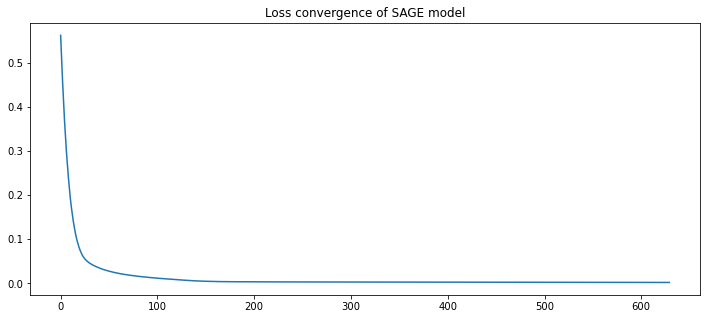



Plot with true labels
---------------------


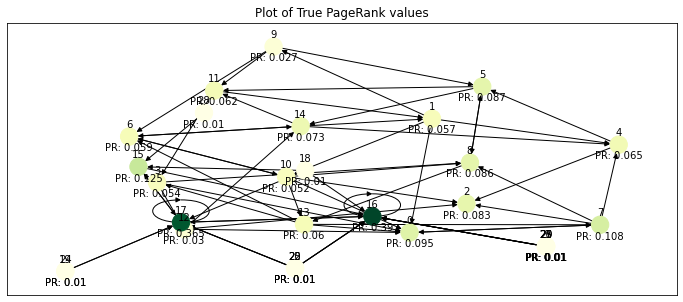

Plot with predicted labels
--------------------------


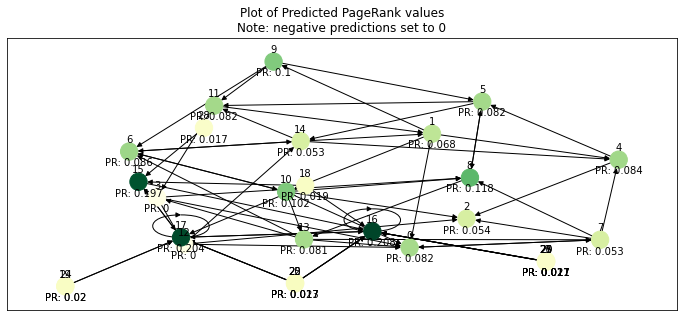

Ground Truth vs. Predictions
--------------------------


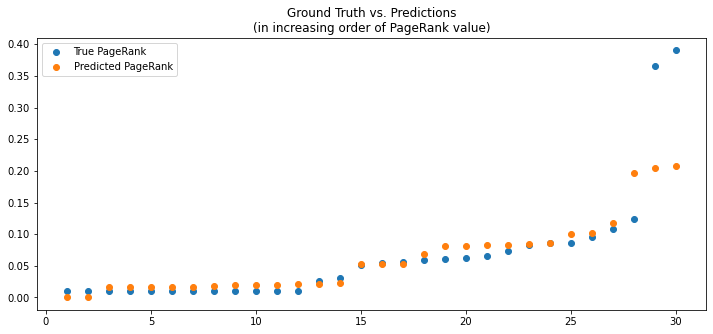

In [69]:
SAGE_model_adamw_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.482618;		val loss 0.258401
Epoch 50,	loss: 0.021081;		val loss 0.019637
Epoch 100,	loss: 0.009159;		val loss 0.01025
Epoch 150,	loss: 0.006784;		val loss 0.006905
Epoch 200,	loss: 0.005544;		val loss 0.005241
Epoch 250,	loss: 0.004655;		val loss 0.004322
Epoch 300,	loss: 0.003957;		val loss 0.003769
Epoch 350,	loss: 0.003335;		val loss 0.003415
Epoch 400,	loss: 0.002863;		val loss 0.003146
Epoch 450,	loss: 0.002507;		val loss 0.00297
Epoch 500,	loss: 0.002249;		val loss 0.002852
Epoch 550,	loss: 0.002046;		val loss 0.002767
Epoch 600,	loss: 0.001874;		val loss 0.002708
Epoch 650,	loss: 0.001731;		val loss 0.002682
Epoch 700,	loss: 0.001608;		val loss 0.002655
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 741             ####
Final train loss: 0.001523, validation loss: 0.002647891640663147.
Test loss: 0.000642


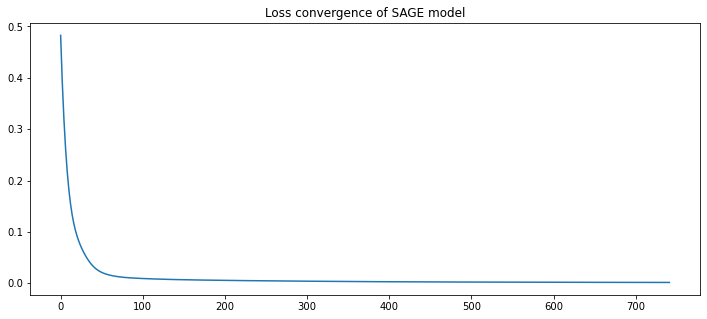



Plot with true labels
---------------------


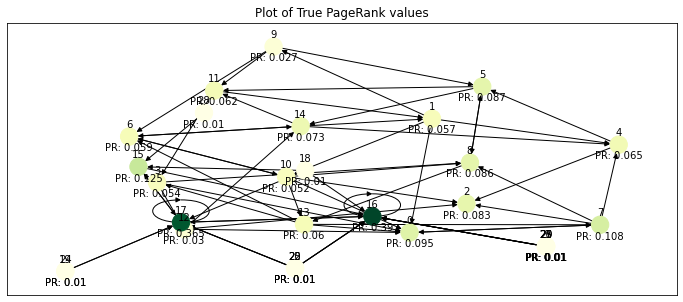

Plot with predicted labels
--------------------------


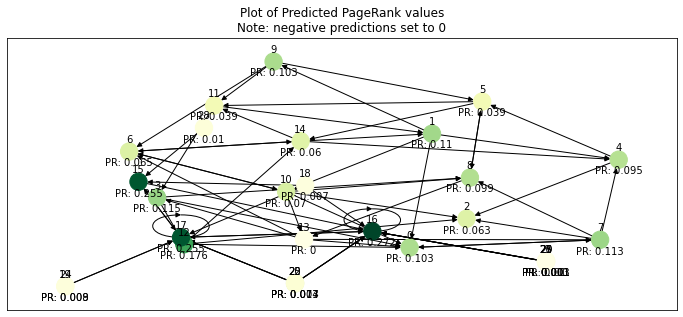

Ground Truth vs. Predictions
--------------------------


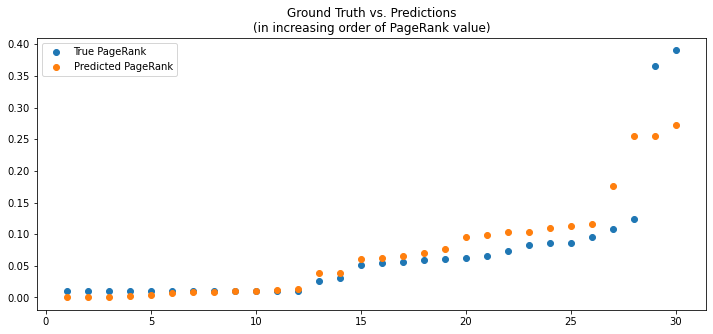

In [70]:
SAGE_model_adamax_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.187701;		val loss 0.094151
Epoch 50,	loss: 0.185332;		val loss 0.093192
Epoch 100,	loss: 0.182611;		val loss 0.092188
Epoch 150,	loss: 0.17962;		val loss 0.091162
Epoch 200,	loss: 0.176406;		val loss 0.090124
Epoch 250,	loss: 0.173006;		val loss 0.089089
Epoch 300,	loss: 0.169452;		val loss 0.088055
Epoch 350,	loss: 0.165771;		val loss 0.087
Epoch 400,	loss: 0.161995;		val loss 0.085916
Epoch 450,	loss: 0.158135;		val loss 0.084806
Epoch 500,	loss: 0.154212;		val loss 0.08367
Epoch 550,	loss: 0.150243;		val loss 0.082512
Epoch 600,	loss: 0.146243;		val loss 0.081334
Epoch 650,	loss: 0.142227;		val loss 0.08014
Epoch 700,	loss: 0.138206;		val loss 0.078931
Epoch 750,	loss: 0.134193;		val loss 0.077711
Epoch 800,	loss: 0.130198;		val loss 0.076481
Epoch 850,	loss: 0.126231;		val loss 0.075243
Epoch 900,	loss: 0.1223;		val loss 0.073999
Epoch 950,	loss: 0.118412;		val loss 0.07275
Final train loss: 0.114651, validation loss: 0.071521.
Test loss: 0.019985


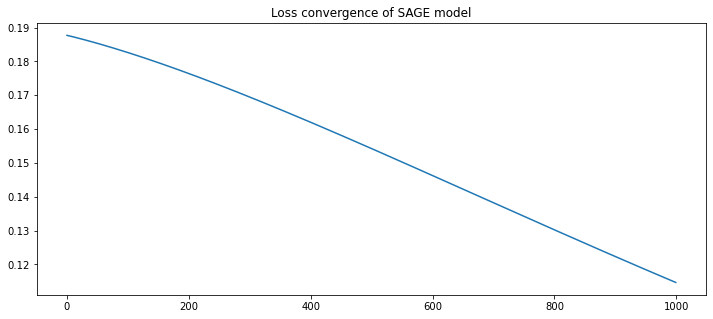



Plot with true labels
---------------------


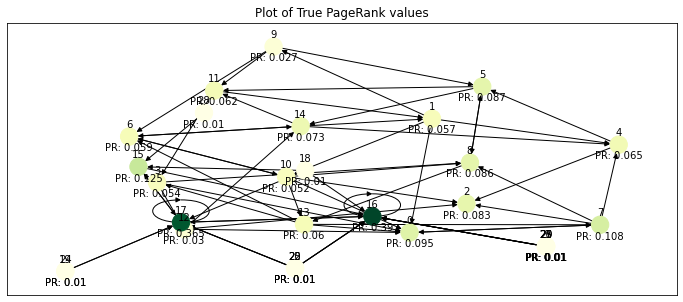

Plot with predicted labels
--------------------------


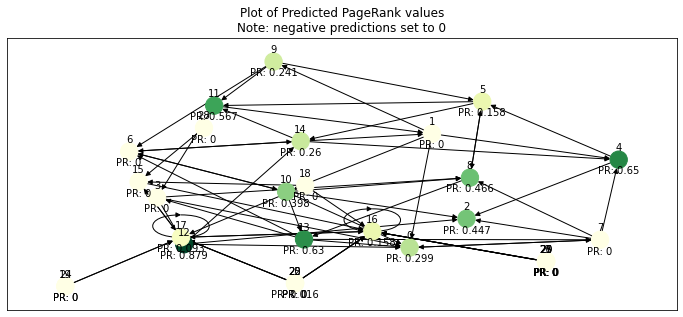

Ground Truth vs. Predictions
--------------------------


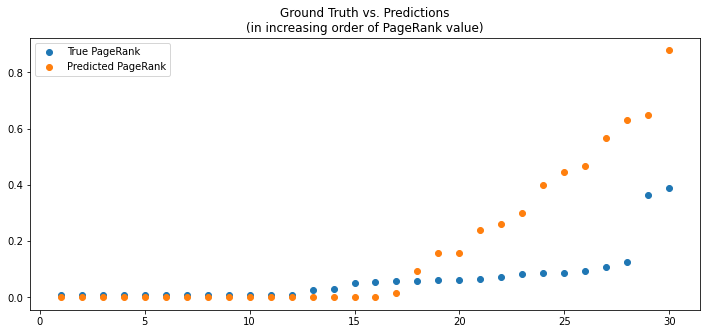

In [71]:
SAGE_model_adadelta_noise.run(print_graph_results=True)

Epoch 0,	loss: 2.646479;		val loss 0.295278
Epoch 50,	loss: 0.277966;		val loss 0.144772
Epoch 100,	loss: 0.159886;		val loss 0.108309
Epoch 150,	loss: 0.111684;		val loss 0.079421
Epoch 200,	loss: 0.082256;		val loss 0.059267
Epoch 250,	loss: 0.062868;		val loss 0.045323
Epoch 300,	loss: 0.049499;		val loss 0.035416
Epoch 350,	loss: 0.039872;		val loss 0.028178
Epoch 400,	loss: 0.032928;		val loss 0.022948
Epoch 450,	loss: 0.027892;		val loss 0.019081
Epoch 500,	loss: 0.024155;		val loss 0.016178
Epoch 550,	loss: 0.021311;		val loss 0.014041
Epoch 600,	loss: 0.019033;		val loss 0.01236
Epoch 650,	loss: 0.017248;		val loss 0.011023
Epoch 700,	loss: 0.015814;		val loss 0.009959
Epoch 750,	loss: 0.014646;		val loss 0.009098
Epoch 800,	loss: 0.013675;		val loss 0.008392
Epoch 850,	loss: 0.012854;		val loss 0.007805
Epoch 900,	loss: 0.012154;		val loss 0.007315
Epoch 950,	loss: 0.011636;		val loss 0.006936
Final train loss: 0.011181, validation loss: 0.006609.
Test loss: 0.000706


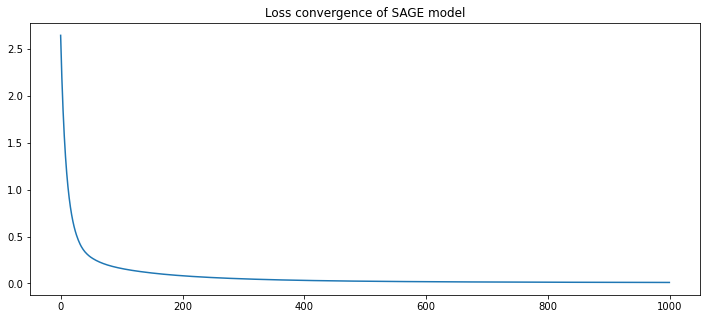



Plot with true labels
---------------------


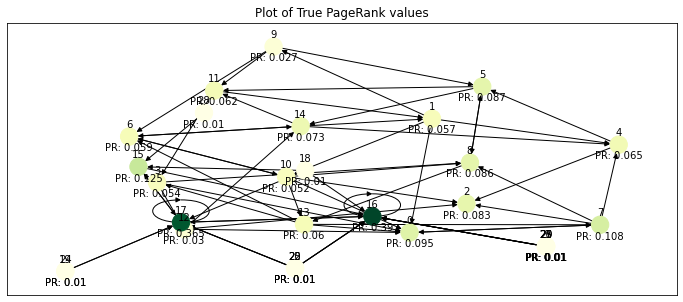

Plot with predicted labels
--------------------------


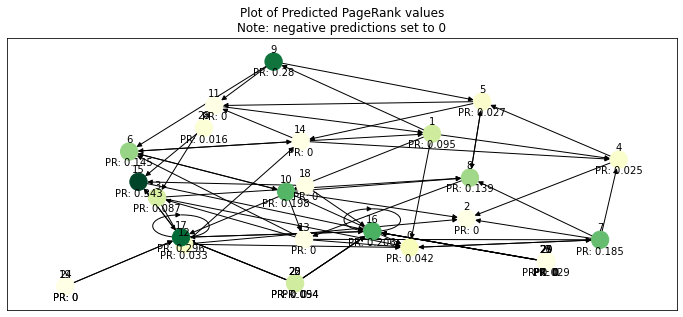

Ground Truth vs. Predictions
--------------------------


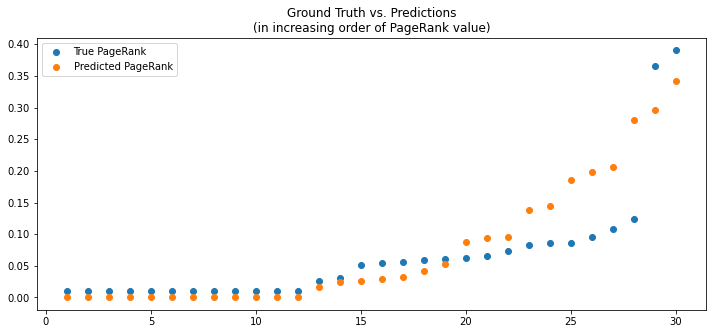

In [72]:
SAGE_model_SGD_noise.run(print_graph_results=True)

<u>Convolutional GNN models (graph with torcheye as feature):</u>

Epoch 0,	loss: 0.015331;		val loss 0.002101
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 19             ####
Final train loss: 0.000679, validation loss: 0.0011543340515345335.
Test loss: 2e-05


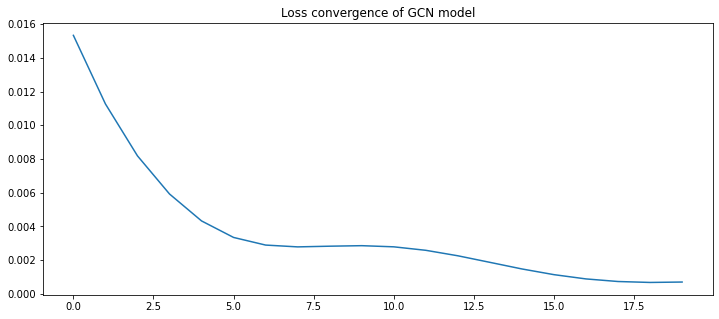



Plot with true labels
---------------------


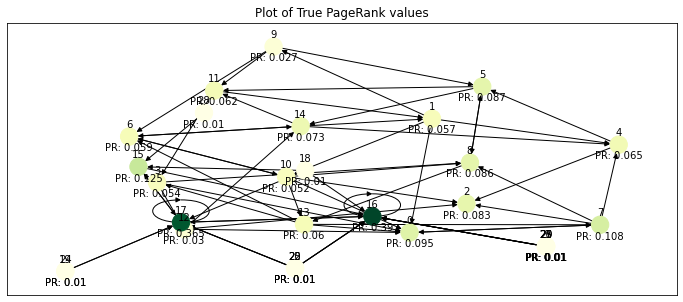

Plot with predicted labels
--------------------------


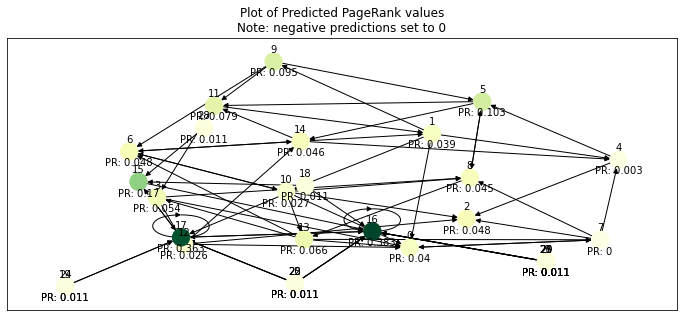

Ground Truth vs. Predictions
--------------------------


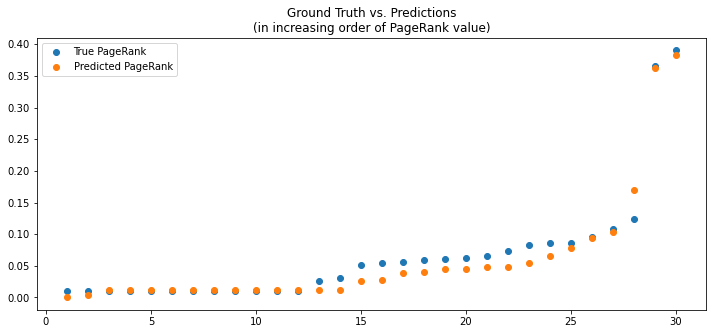

In [73]:
GCN_model_adam_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.009019;		val loss 0.000685
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 31             ####
Final train loss: 0.00049, validation loss: 0.0002531835634727031.
Test loss: 4.8e-05


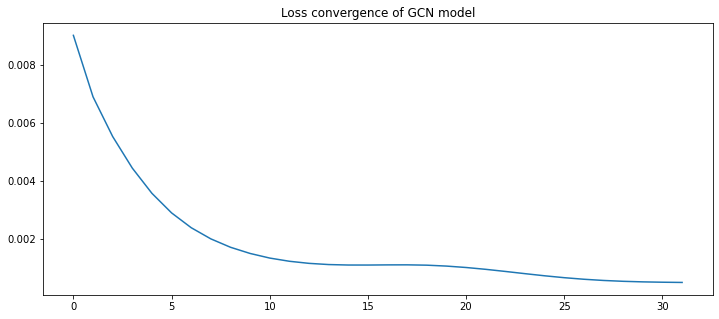



Plot with true labels
---------------------


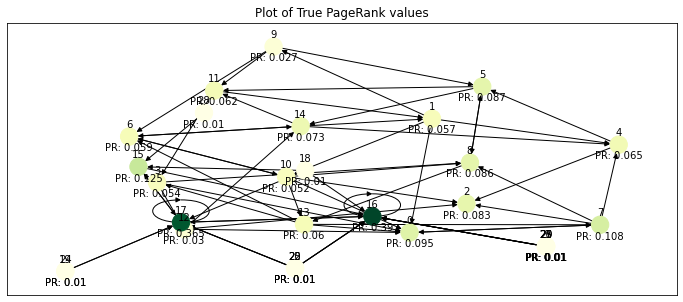

Plot with predicted labels
--------------------------


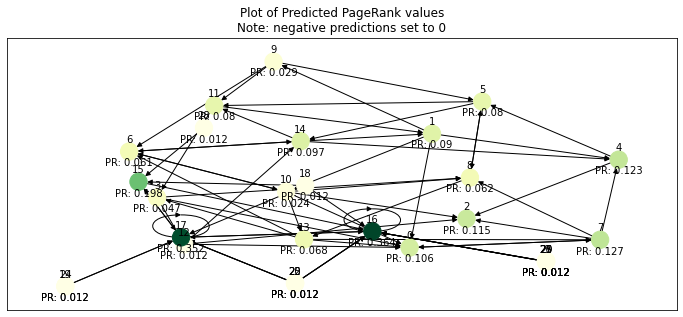

Ground Truth vs. Predictions
--------------------------


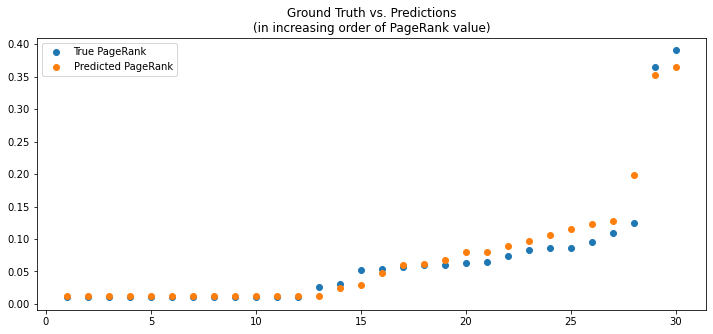

In [74]:
GCN_model_adamw_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.01323;		val loss 0.000751
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 27             ####
Final train loss: 0.000507, validation loss: 0.00019041605992242694.
Test loss: 0.000252


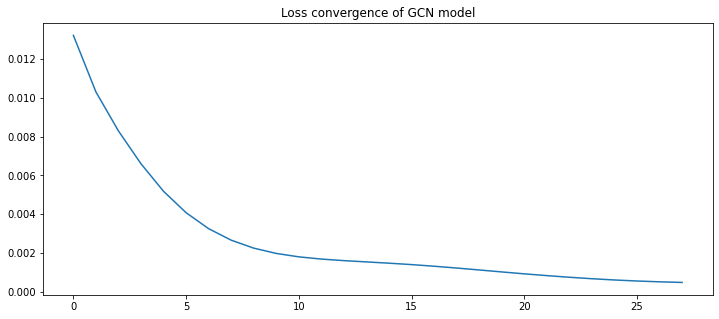



Plot with true labels
---------------------


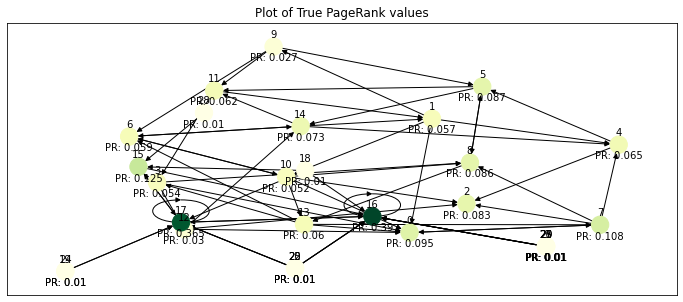

Plot with predicted labels
--------------------------


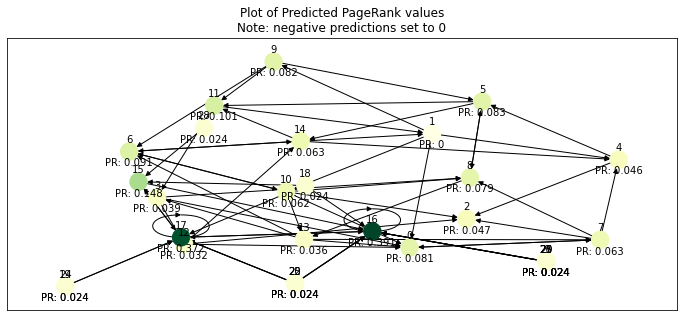

Ground Truth vs. Predictions
--------------------------


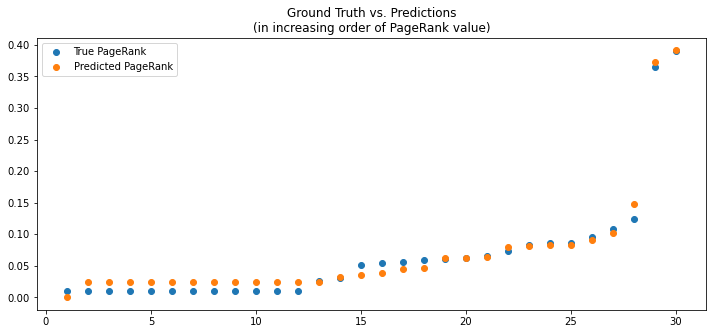

In [75]:
GCN_model_adamax_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.015326;		val loss 0.001327
Epoch 50,	loss: 0.014707;		val loss 0.001272
Epoch 100,	loss: 0.014037;		val loss 0.001213
Epoch 150,	loss: 0.013344;		val loss 0.001153
Epoch 200,	loss: 0.01265;		val loss 0.001092
Epoch 250,	loss: 0.011956;		val loss 0.001032
Epoch 300,	loss: 0.01127;		val loss 0.000974
Epoch 350,	loss: 0.010597;		val loss 0.000918
Epoch 400,	loss: 0.009945;		val loss 0.000866
Epoch 450,	loss: 0.009317;		val loss 0.000822
Epoch 500,	loss: 0.008717;		val loss 0.000782
Epoch 550,	loss: 0.008148;		val loss 0.000746
Epoch 600,	loss: 0.007613;		val loss 0.000713
Epoch 650,	loss: 0.007111;		val loss 0.000684
Epoch 700,	loss: 0.006648;		val loss 0.000659
Epoch 750,	loss: 0.006228;		val loss 0.000638
Epoch 800,	loss: 0.00584;		val loss 0.00062
Epoch 850,	loss: 0.005485;		val loss 0.000605
Epoch 900,	loss: 0.005161;		val loss 0.000592
Epoch 950,	loss: 0.004872;		val loss 0.000583
Final train loss: 0.004617, validation loss: 0.000576.
Test loss: 5e-05


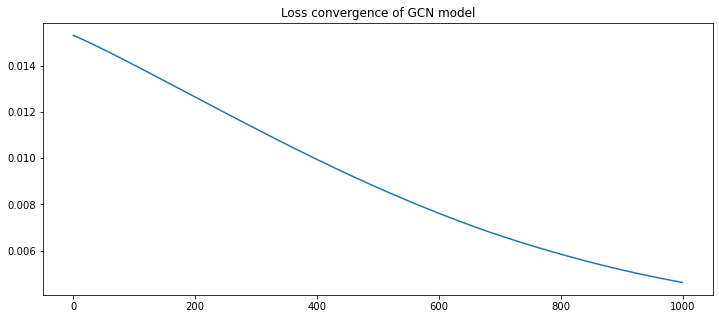



Plot with true labels
---------------------


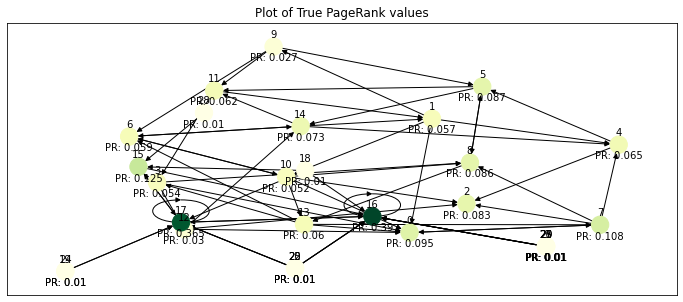

Plot with predicted labels
--------------------------


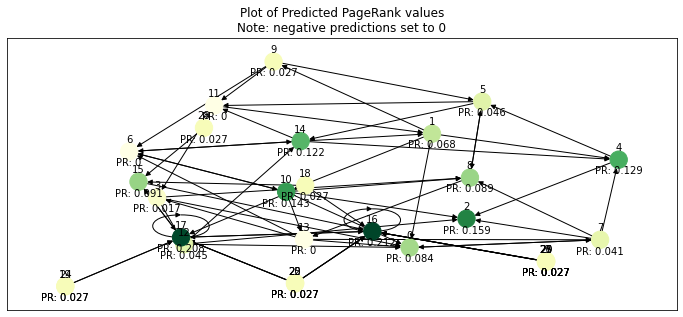

Ground Truth vs. Predictions
--------------------------


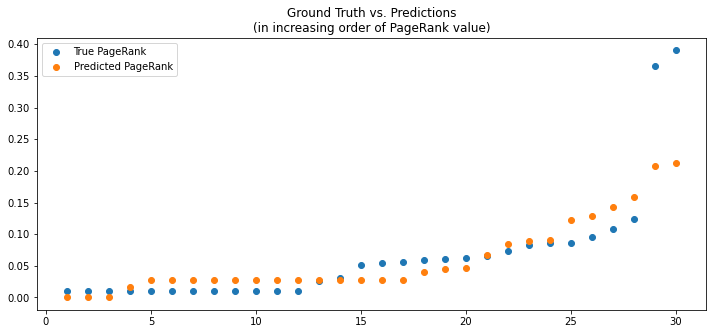

In [76]:
GCN_model_adadelta_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.008495;		val loss 0.000552
Epoch 50,	loss: 0.005296;		val loss 0.000217
Epoch 100,	loss: 0.004281;		val loss 0.000139
Epoch 150,	loss: 0.003782;		val loss 0.000124
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 156             ####
Final train loss: 0.003745, validation loss: 0.00012436402903404087.
Test loss: 7e-06


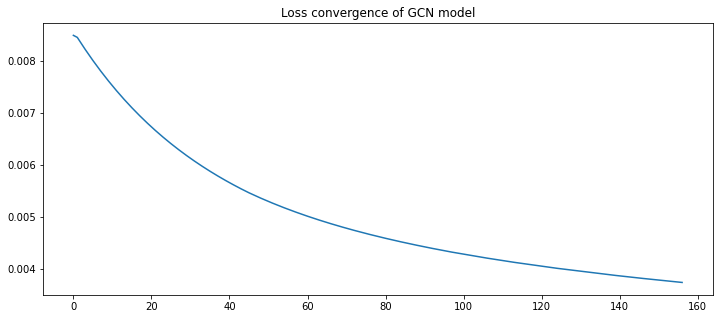



Plot with true labels
---------------------


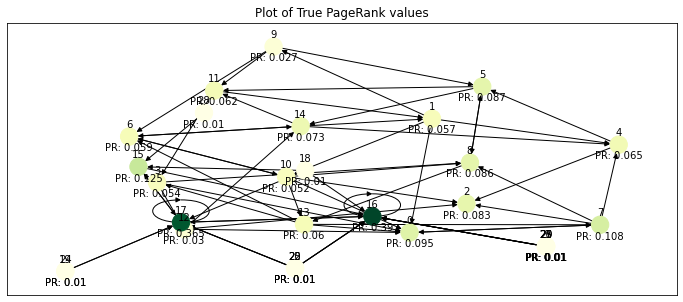

Plot with predicted labels
--------------------------


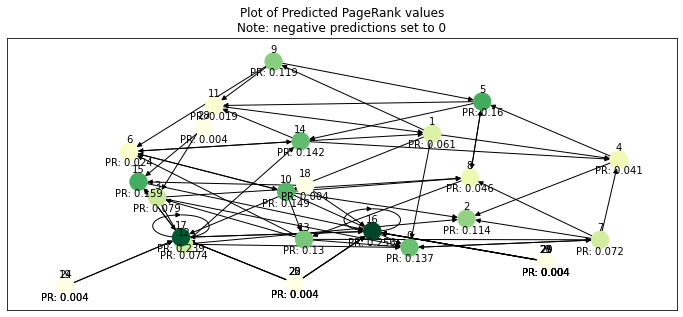

Ground Truth vs. Predictions
--------------------------


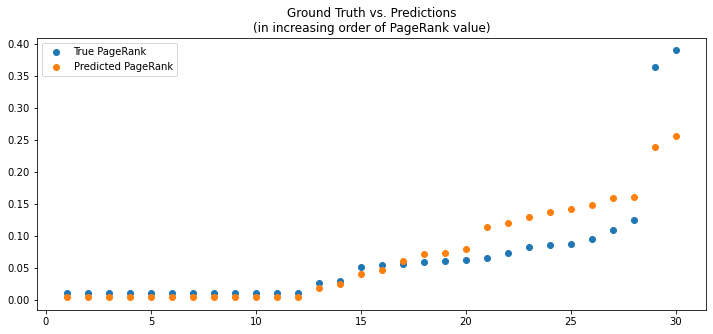

In [77]:
GCN_model_SGD_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.056194;		val loss 0.006923
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 26             ####
Final train loss: 0.002399, validation loss: 0.0014295375440269709.
Test loss: 0.003513


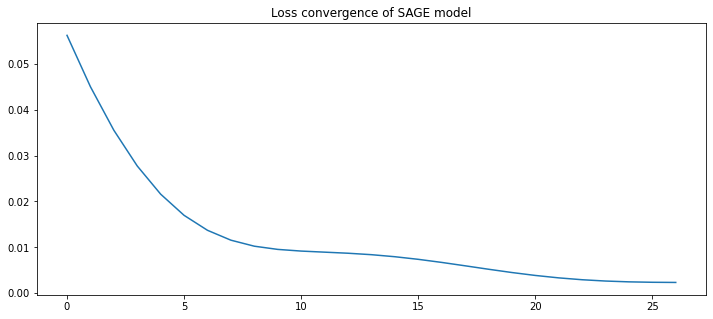



Plot with true labels
---------------------


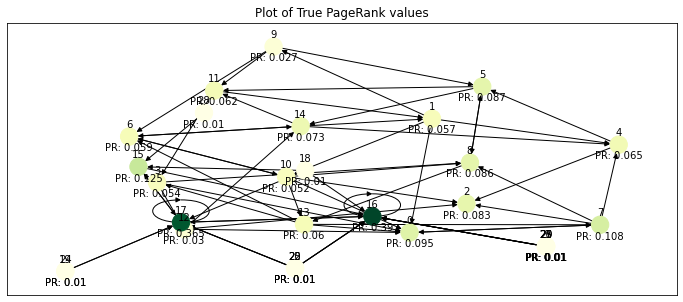

Plot with predicted labels
--------------------------


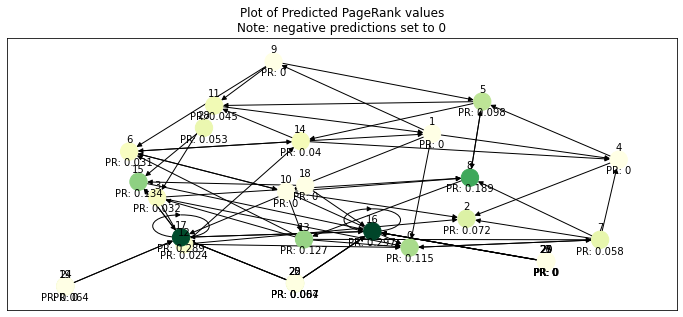

Ground Truth vs. Predictions
--------------------------


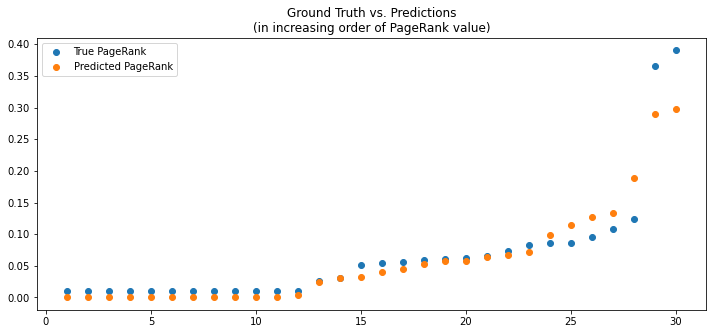

In [78]:
SAGE_model_adam_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.150658;		val loss 0.020262
Epoch 50,	loss: 0.000742;		val loss 0.008864
Epoch 100,	loss: 5.9e-05;		val loss 0.007064
Epoch 150,	loss: 1e-05;		val loss 0.006405
Epoch 200,	loss: 2e-06;		val loss 0.006081
Epoch 250,	loss: 0.0;		val loss 0.00592
Epoch 300,	loss: 0.0;		val loss 0.005832
Epoch 350,	loss: 0.0;		val loss 0.005776
Epoch 400,	loss: 0.0;		val loss 0.005734
Epoch 450,	loss: 0.0;		val loss 0.005696
Epoch 500,	loss: 0.0;		val loss 0.005659
Epoch 550,	loss: 0.0;		val loss 0.005622
Epoch 600,	loss: 0.0;		val loss 0.005587
Epoch 650,	loss: 0.0;		val loss 0.005551
Epoch 700,	loss: 0.0;		val loss 0.005516
Epoch 750,	loss: 0.0;		val loss 0.005481
Epoch 800,	loss: 0.0;		val loss 0.005446
Epoch 850,	loss: 0.0;		val loss 0.005411
Epoch 900,	loss: 0.0;		val loss 0.005377
Epoch 950,	loss: 0.0;		val loss 0.005343
Final train loss: 0.0, validation loss: 0.00531.
Test loss: 0.004397


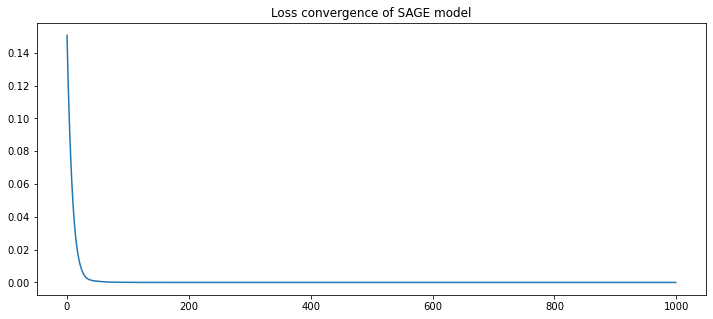



Plot with true labels
---------------------


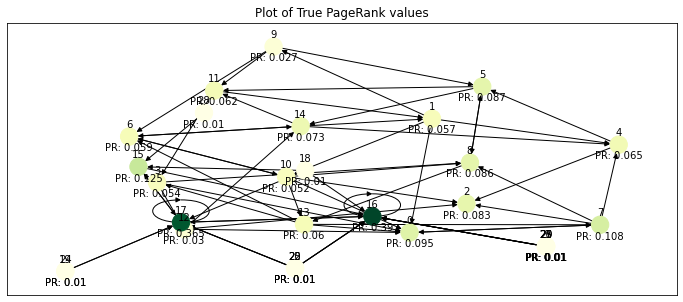

Plot with predicted labels
--------------------------


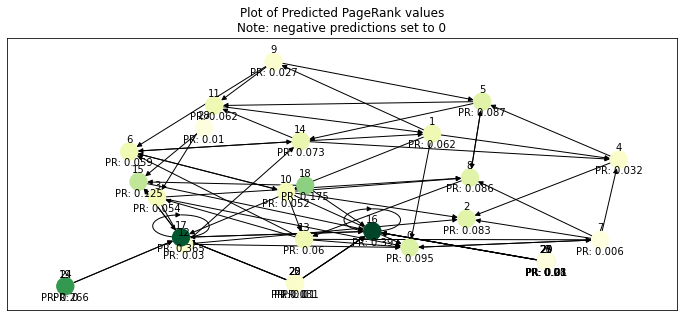

Ground Truth vs. Predictions
--------------------------


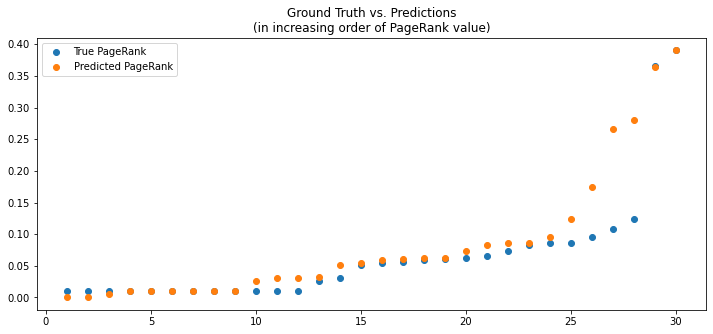

In [79]:
SAGE_model_adamw_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.116278;		val loss 0.015628
Epoch 50,	loss: 0.002899;		val loss 0.006167
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 58             ####
Final train loss: 0.002054, validation loss: 0.006238526664674282.
Test loss: 0.011109


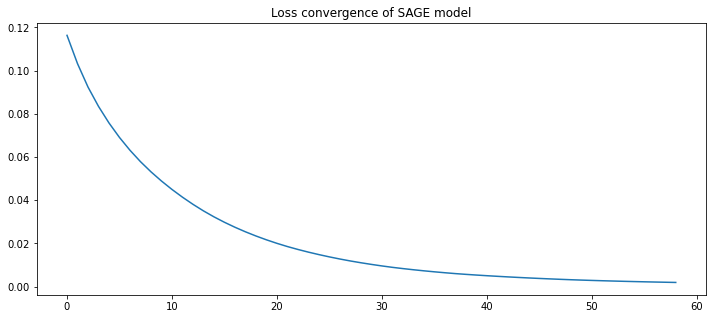



Plot with true labels
---------------------


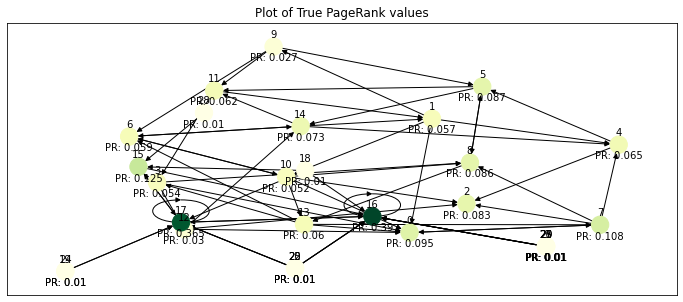

Plot with predicted labels
--------------------------


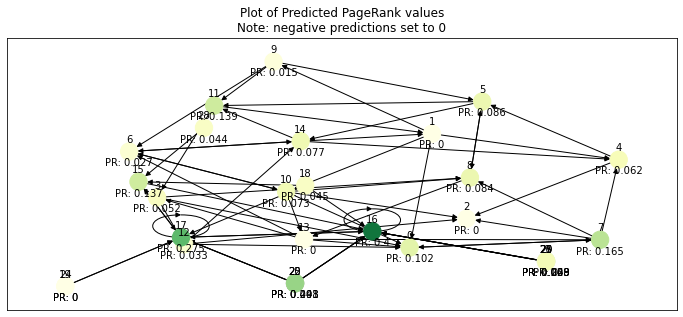

Ground Truth vs. Predictions
--------------------------


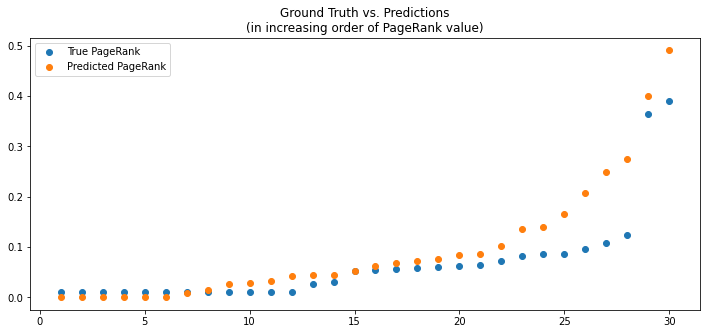

In [80]:
SAGE_model_adamax_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.269151;		val loss 0.088716
Epoch 50,	loss: 0.263472;		val loss 0.088354
Epoch 100,	loss: 0.257007;		val loss 0.087949
Epoch 150,	loss: 0.249968;		val loss 0.087507
Epoch 200,	loss: 0.242476;		val loss 0.087042
Epoch 250,	loss: 0.234634;		val loss 0.086565
Epoch 300,	loss: 0.22653;		val loss 0.086083
Epoch 350,	loss: 0.218239;		val loss 0.085599
Epoch 400,	loss: 0.209827;		val loss 0.085119
Epoch 450,	loss: 0.201351;		val loss 0.084645
Epoch 500,	loss: 0.192862;		val loss 0.084179
Epoch 550,	loss: 0.184406;		val loss 0.083723
Epoch 600,	loss: 0.176021;		val loss 0.083279
Epoch 650,	loss: 0.167742;		val loss 0.082847
Epoch 700,	loss: 0.1596;		val loss 0.08243
Epoch 750,	loss: 0.151622;		val loss 0.082027
Epoch 800,	loss: 0.14383;		val loss 0.08164
Epoch 850,	loss: 0.136243;		val loss 0.081269
Epoch 900,	loss: 0.12888;		val loss 0.080914
Epoch 950,	loss: 0.122357;		val loss 0.080541
Final train loss: 0.116168, validation loss: 0.080185.
Test loss: 0.011661


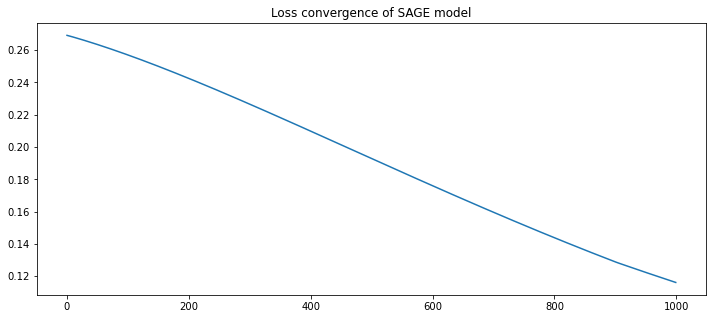



Plot with true labels
---------------------


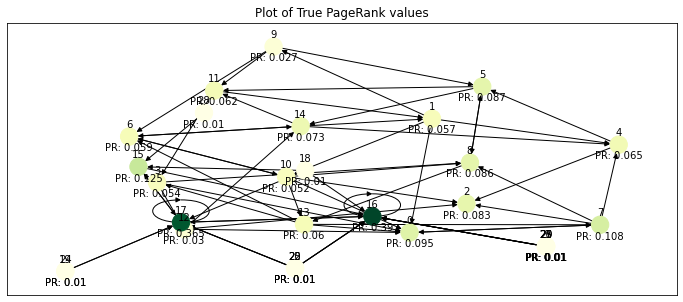

Plot with predicted labels
--------------------------


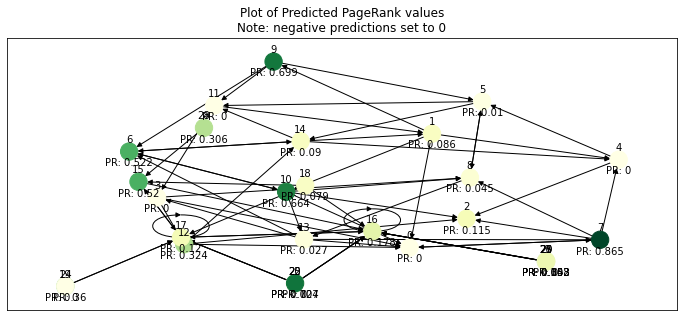

Ground Truth vs. Predictions
--------------------------


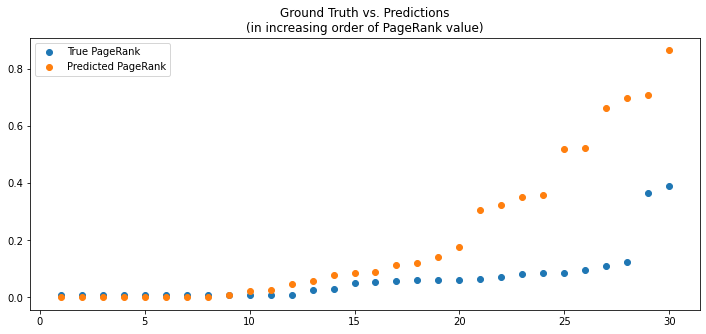

In [81]:
SAGE_model_adadelta_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.699778;		val loss 0.074571
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 12             ####
Final train loss: 0.465453, validation loss: 0.07696058601140976.
Test loss: 0.026208


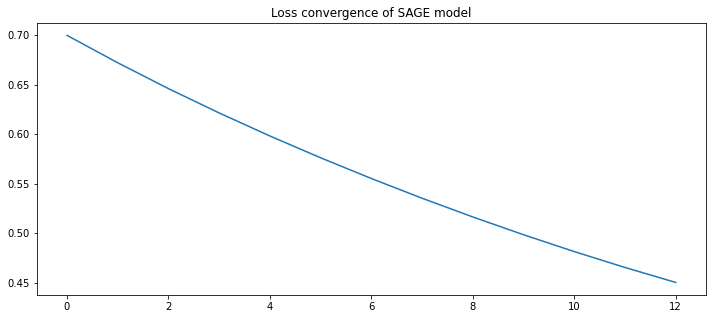



Plot with true labels
---------------------


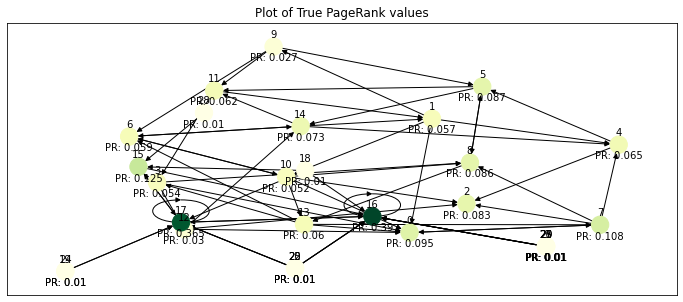

Plot with predicted labels
--------------------------


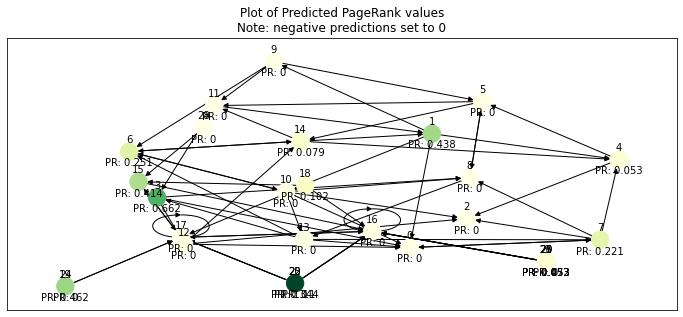

Ground Truth vs. Predictions
--------------------------


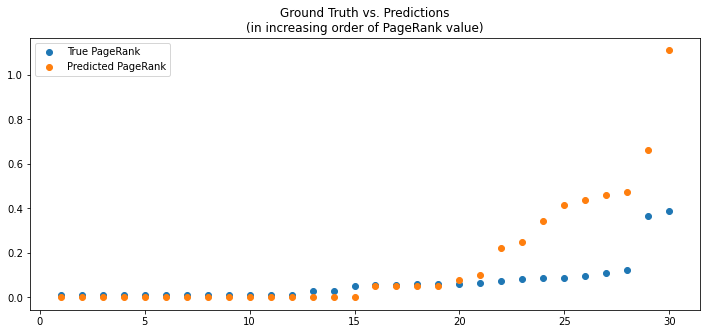

In [82]:
SAGE_model_SGD_eye.run(print_graph_results=True)

## 4. Reproducing the PageRank setup from "The Graph Neural Network Model"

> "A random web graph $\mathcal{G}$ with 5000 nodes and $\delta=0.2$ [*$\delta$ corresponds to the probability to connect two nodes*]. Training, validation, and test sets consisted of different nodes of this graph. More precisely, only 50 nodes were supervised in the training set, other 50 nodes belonged to the validation set, and the remaining nodes were in the test set."

We reduce the number of nodes to 1000 to be able to work on a personal computer. We keep the number of train and validation nodes to 50 respectively.

<u>Note:</u>

Impossible due to memory capacity being insufficient at the time.

## 5. Discussing the Results

Following are the training and validation losses obtained during a run performed on February 20th, 2022. 

<u>Graph Neural Networks with Relaxation</u>
- *Hidden states*: 5
- *Number of epochs*: 1000

| Optimizer | End Training Loss | End Validation Loss | Comment |
| --- | --- | --- | --- |
| Adam | 0.0005 | 0.0234 | **OK**, results okay for first 24 nodes, nodes 29, 30 skew results for nodes 25-28 |
| AdamW | 0.0072 | 0.0175 | *NOK*, predictions stuck between 0.04-0.08, 1 negative node value |
| Adamax | 0.0001 | 0.0183 | *NOK*, one negative node but all other nodes except 29 very close to true value |
| Adadelta | 0.1614 | 0.1388 | *NOK*, predictions stuck between 0.4-0.5 |
| SGD | 0.0066 | 0.0203 | *NOK*, Predictions stuck around 0.05 |

<u>Graph Convolutional Neural Networks</u>
- *Hidden states*: 5
- *Number of epochs*: 1000

| Feature type | Optimizer | End Training Loss | End Validation Loss | Comment |
| --- | --- | --- | --- | --- |
| Noise | Adam | 0.0062 | 0.0013 | *NOK*, overpredicts nodes 1 to 28, skewing toward top 2 nodes |
| Noise | AdamW | 0.0098 | 0.0008 | *NOK*, predictions stuck between 0.0 and 0.1 |
| Noise | Adamax | 0.0049 | 0.001 | *NOK*, predictions okay-ish for nodes 1 to 28, underpredicts for nodes 29, 30 |
| Noise | Adadelta | 0.0079 | 0.003 | *NOK*, overpredicts nodes 25-28, underpredicts nodes 29, 30 |
| Noise | SGD | 0.0037 | 0.0003 | *NOK*, predictions close to ground truth for nodes 1-28, underpredicts nodes 29, 30 |
| Torch Eye | Adam | 0.0007 | 0.0012 | **OK**, very close to ground truth |
| Torch Eye | AdamW | 0.0005 | 0.0003 | **OK**, very close to ground truth except node 28 |
| Torch Eye | Adamax | 0.0005 | 0.0002 | **OK**, very close to ground truth |
| Torch Eye | Adadelta | 0.0046 | 0.0006 | *NOK*, overpredicts nodes 25-28, underpredicts nodes 29, 30 |
| Torch Eye | SGD | 0.0037 | 0.0001 | *NOK*, overpredicts nodes 21-28, underpredicts nodes 29, 30 |

<u>SAGE Graph Neural Networks</u>
- *Hidden states*: 5
- *Number of epochs*: 1000

| Feature type | Optimizer | End Training Loss | End Validation Loss | Comment |
| --- | --- | --- | --- | --- |
| Noise | Adam | 0.0063 | 0.0013 | *NOK*, predictions close to ground truth for nodes 1-28, underpredicts nodes 29, 30 |
| Noise | AdamW | 0.0023 | 0.0007 | *NOK*, overpredicts node 28, underpredicts nodes 29, 30 |
| Noise | Adamax | 0.0015 | 0.0026 | *NOK*, overpredicts nodes, 27, 28, underpredicts nodes 29, 30 |
| Noise | Adadelta | 0.1147 | 0.0715 | *NOK*, overpredicts nodes 18 to 30 |
| Noise | SGD | 0.0112 | 0.0066 | *NOK*, overpredicts nodes 20-28, underpredicts nodes 29, 30k |
| Torch Eye | Adam | 0.0024 | 0.0014 | *NOK*, underpredicts nodes 29, 30 |
| Torch Eye | AdamW | 0.0 | 0.0053 | *NOK*, overpredicts nodes 25-28 (but largest nodes near exact) |
| Torch Eye | Adamax | 0.0021 | 0.0062 | *NOK*, overpredicts nodes 22-30 |
| Torch Eye | Adadelta | 0.1161 | 0.0802 | *NOK*, overpredicts nodes 17-30 |
| Torch Eye | SGD | 0.4655 | 0.077 | *NOK*, overpredicts nodes 21-30 |